In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import scipy
import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import fbpca

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 20.0
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
import pickle

In [4]:
import graph_learning_utils as gl

# Rewrite algo for faster runs

In [5]:
def objective_with_params_sparse(eta_arr, validation_mat, 
        sample_mats, delta, num_eigs_included=None, verbose=False, use_random_svd=True):
    if num_eigs_included is None:
        num_eigs_included = validation_mat.shape[0]
    P_hat = gl.matrix_lin_combo_pos_sign(eta_arr, sample_mats, sparse=True)

    # singular values, increasing order
    # print('running svd with {} singular values'.format(num_eigs_included))
    if use_random_svd: 
        # print('using random svd with k={}'.format(num_eigs_included))
        # eigvals, _ = fbpca.eigens(validation_mat - P_hat, k = num_eigs_included)
        U, S, Vh = fbpca.pca(validation_mat - P_hat, k = num_eigs_included, n_iter=4)
        diff_sing_values = S
    else: 
        sing_vals = scipy.sparse.linalg.svds(validation_mat - P_hat, solver='arpack',
                                                k=num_eigs_included - 1, return_singular_vectors=False)
        diff_sing_values = np.flip(sing_vals)

    # assumes sing values are in decrasing order
    def ob_fn(k): 
        return sum(diff_sing_values[k:]) - k * delta

    all_obj_values = [ob_fn(k) for k in range(1, num_eigs_included + 1)]
    max_obj_index = np.argmax(all_obj_values)
    # print(all_obj_values, max_obj_index)
    return all_obj_values[max_obj_index]

# Import data

In [6]:
human_ppi_mat = scipy.sparse.load_npz('data/adj_matrix_sparse_restricted_9606.npz')
max_degree =  np.max(human_ppi_mat)
human_ppi_mat /= max_degree

## generate data for run

In [8]:
m = 5 
occlusion_rate = 0.01
occluded_ground_truths = [gl.gen_occluded_p(human_ppi_mat, frac_to_occlude=occlusion_rate) for _ in range(m)]
validation_mat = gl.gen_sparse_sample_boolean_mat(human_ppi_mat)
sample_mats = [gl.gen_sparse_sample_boolean_mat(occluded_ground_truth) for occluded_ground_truth in occluded_ground_truths]

## try BFGS with randomized eigvals

In [11]:
eta_init = gl.generate_random_eta(m)
delta_scaling = 0.1
delta = gl.delta_estimate(validation_mat, scaling=delta_scaling)
num_eigs_to_include = 10

objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True, 
                                                         num_eigs_included=num_eigs_to_include)
bfgs_options = {
    'iprint': 5, 
    'maxiter': 500, 
    'ftol': 1e-12, 
    'gtol': 1e-12, 
}

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options=bfgs_options
)

using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89294D+02    |proj g|=  9.45510D-01
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random sv

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[18.0277161]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 17 instead with accuracy 
4.883691939496698.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[4.88369194]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


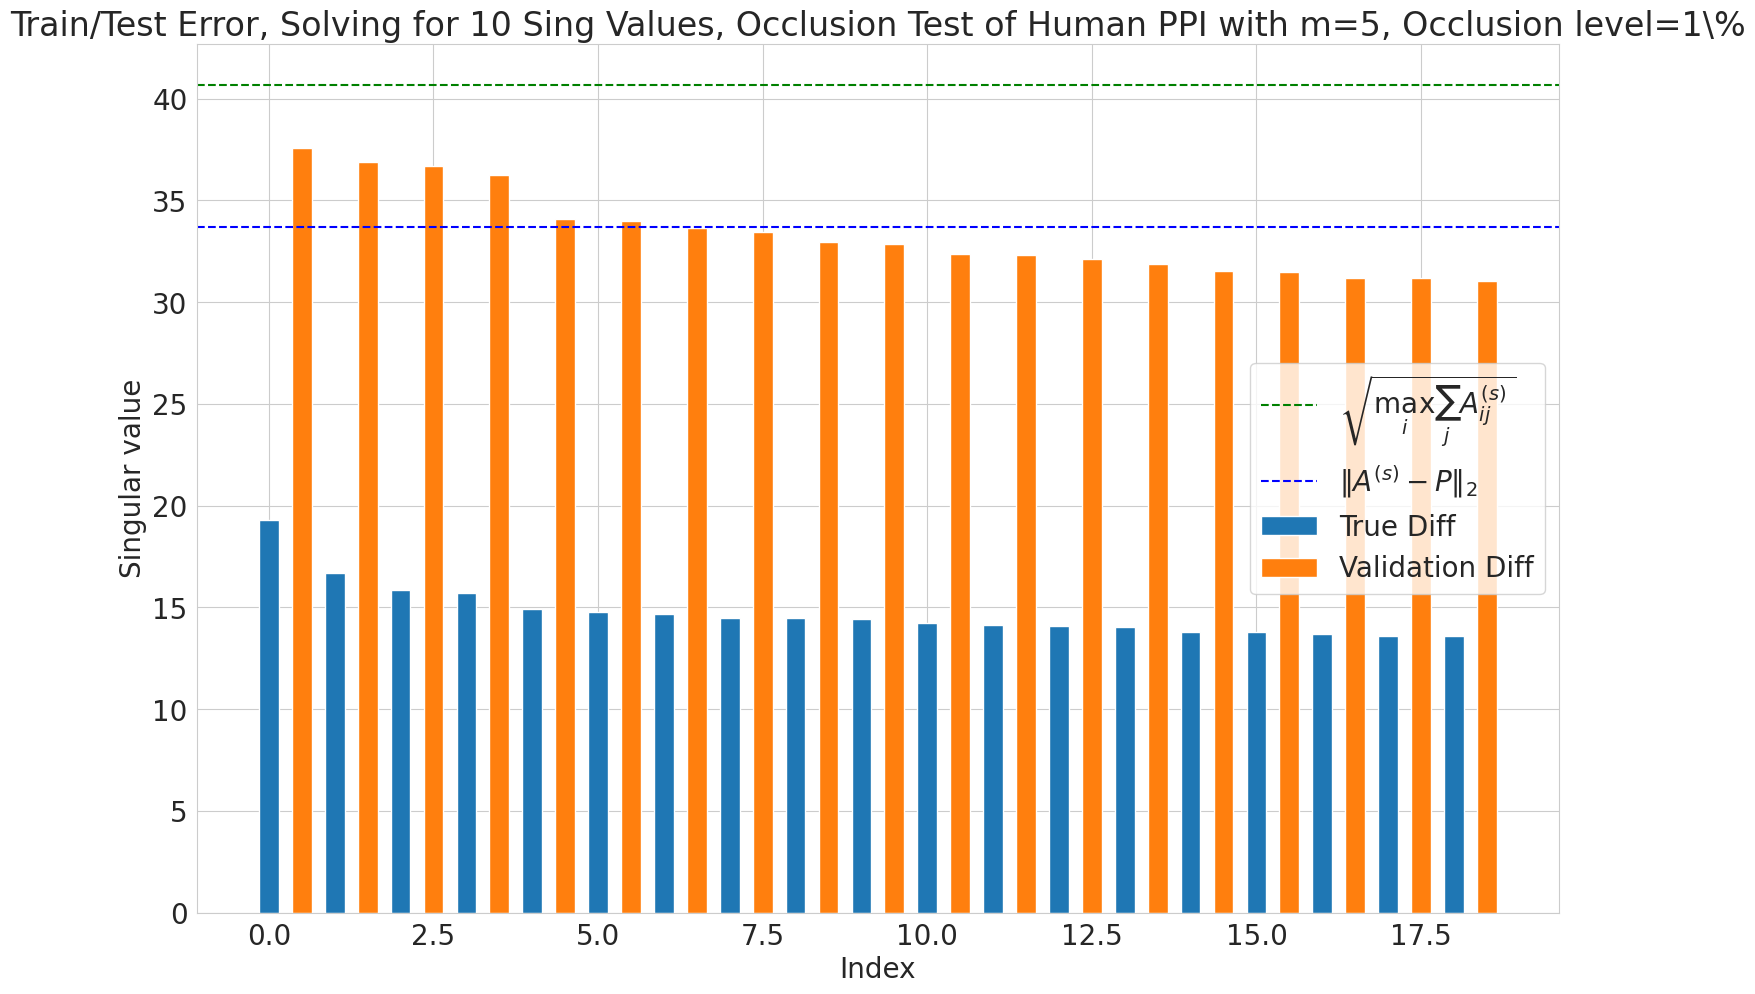

In [13]:
gl.plot_scipy_optimize_result_and_save(result, sample_mats, validation_mat, human_ppi_mat, num_eigs_to_include, 20)

Questions: 

* Why is true error always lower than test error? 

* Why is the true delta so high here? Shouldn't it be much lower? 

* Does using a relatively high delta help in convergence? We used around delta=4 here. 

* Can we use an even smaller ftol/gtol?

In [16]:
result_ftol_1e12 = result.copy()

### bfgs with no ftol setting

In [19]:
eta_init = gl.generate_random_eta(m)
delta_scaling = 0.1
delta = gl.delta_estimate(validation_mat, scaling=delta_scaling)
num_eigs_to_include = 10

objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True, 
                                                         num_eigs_included=num_eigs_to_include, use_random_svd=True)
bfgs_options = {
    'iprint': 5, 
    'maxiter': 500
    # 'ftol': 1e-12, 
    # 'gtol': 1e-12, 
}

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options=bfgs_options
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09325D+02    |proj g|=  9.76206D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     25      7     0     0   9.762D-01   3.079D+02
  F =   307.93582245342105     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[2.3179239]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
2.3179239016093875.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[2.3179239]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


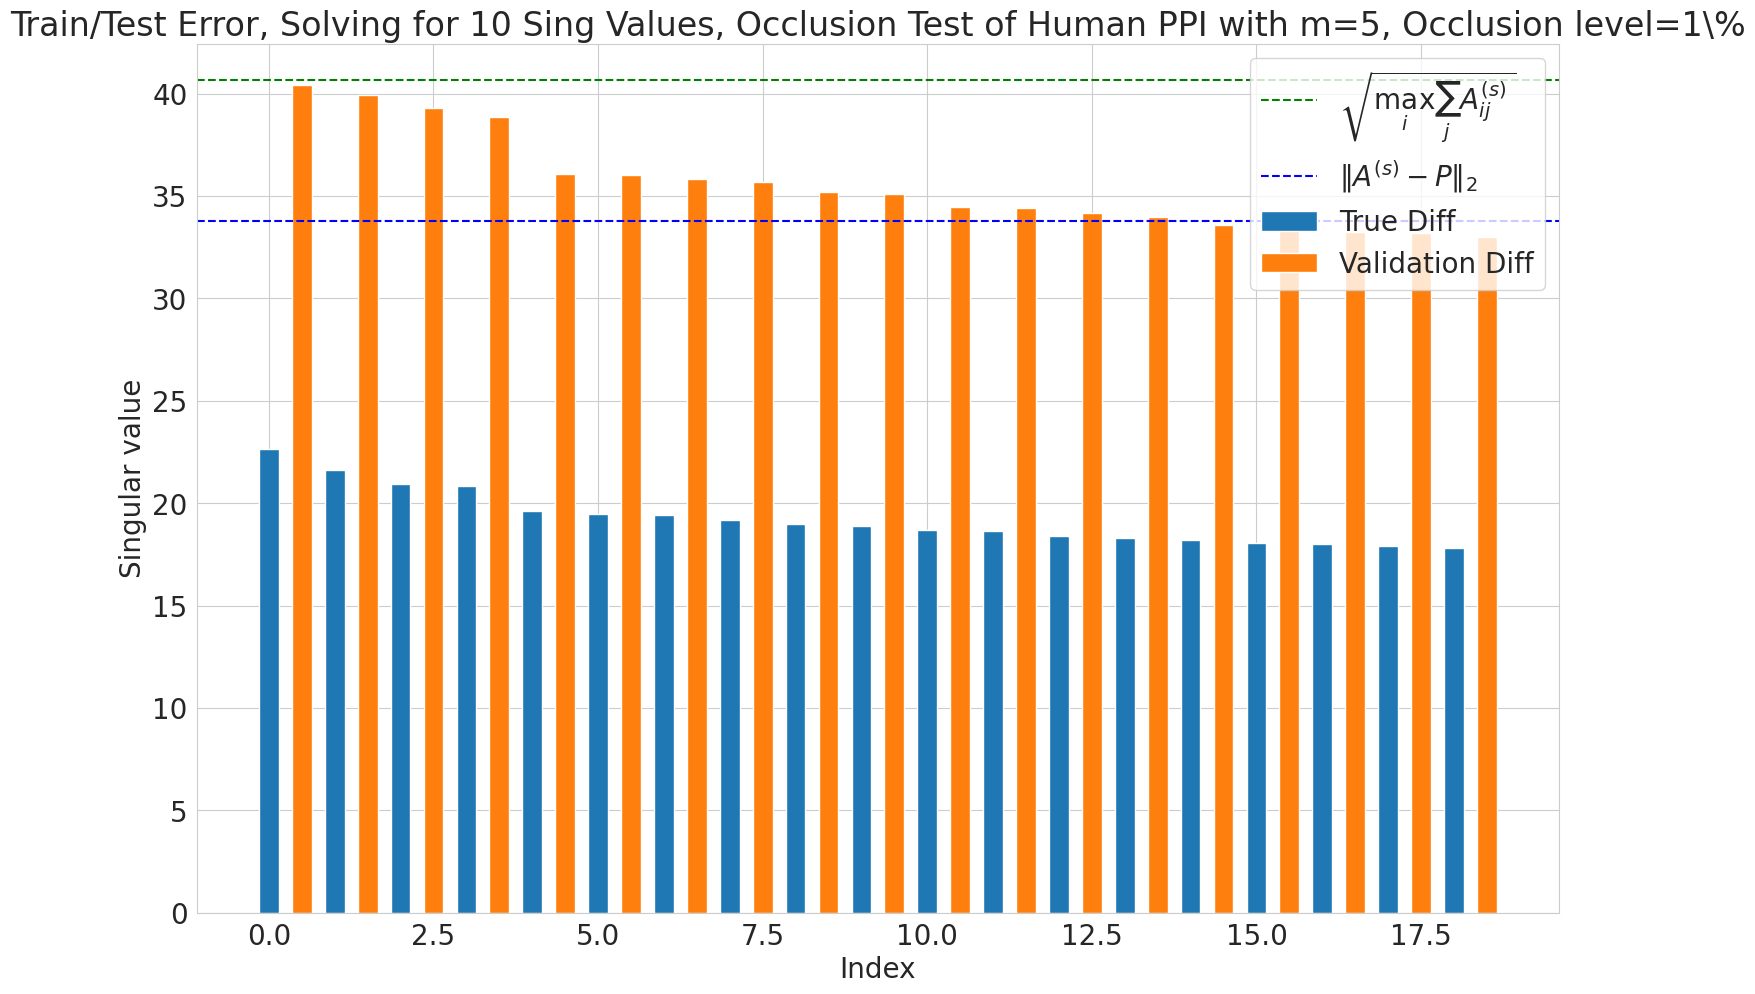

In [20]:
gl.plot_scipy_optimize_result_and_save(result, sample_mats, validation_mat, human_ppi_mat, num_eigs_to_include, 20)

## Better data with hopefully less error

### zero occlusion

In [7]:
m = 10
occlusion_rate = 0.00
occluded_ground_truths = [gl.gen_occluded_p(human_ppi_mat, frac_to_occlude=occlusion_rate) for _ in range(m)]
validation_mat = gl.gen_sparse_sample_boolean_mat(human_ppi_mat)
sample_mats = [gl.gen_sparse_sample_boolean_mat(occluded_ground_truth) for occluded_ground_truth in occluded_ground_truths]

In [8]:
eta_init = gl.generate_random_eta(m)
delta_scaling = 0.1
delta = gl.delta_estimate(validation_mat, scaling=delta_scaling)
num_eigs_to_include = 10

objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True, 
                                                         num_eigs_included=num_eigs_to_include, use_random_svd=True)
bfgs_options = {
    'iprint': 5, 
    'maxiter': 500
    # 'ftol': 1e-12, 
    # 'gtol': 1e-12, 
}

result_no_occlusion = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options=bfgs_options
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76622D+02    |proj g|=  9.59712D-01

           * * *




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      1     20     10     0    10   9.597D-01   2.769D+02
  F =   276.94941111282787     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[2.73411421]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
2.734114205722114.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[2.73411421]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


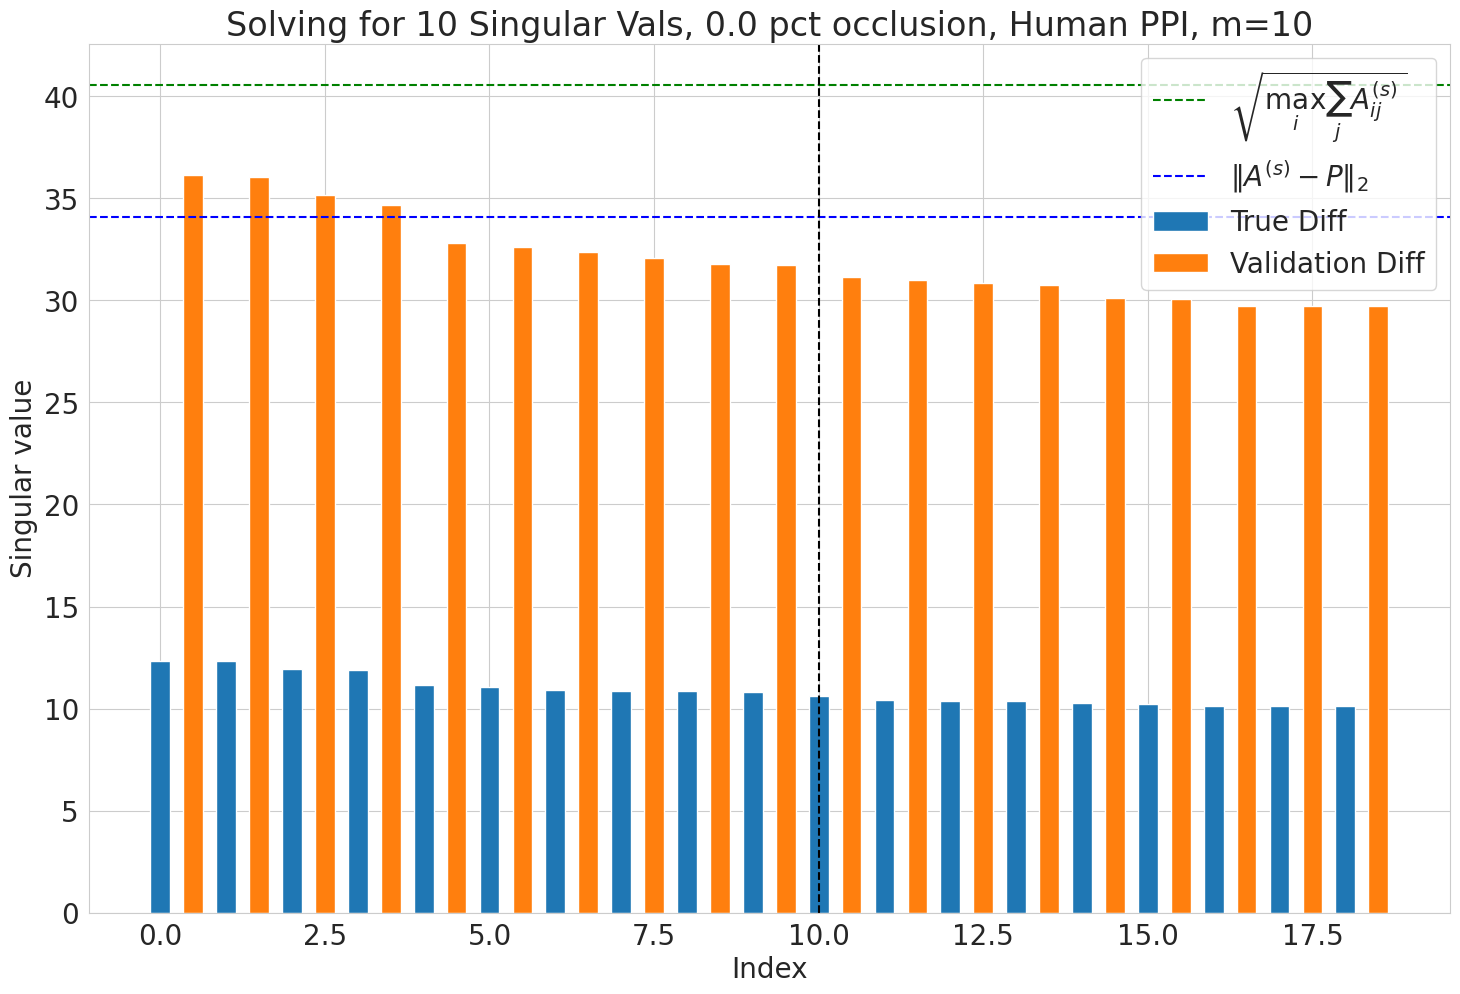

In [11]:
gl.plot_scipy_optimize_result_and_save(result_no_occlusion, sample_mats, validation_mat, 
                                       human_ppi_mat, num_eigs_to_include, 20, m=m, occlusion_level=occlusion_rate)

### huge m

In [12]:
m = 100
occlusion_rate = 0.00
occluded_ground_truths = [gl.gen_occluded_p(human_ppi_mat, frac_to_occlude=occlusion_rate) for _ in range(m)]
validation_mat = gl.gen_sparse_sample_boolean_mat(human_ppi_mat)
sample_mats = [gl.gen_sparse_sample_boolean_mat(occluded_ground_truth) for occluded_ground_truth in occluded_ground_truths]

In [13]:
eta_init = gl.generate_random_eta(m)
delta_scaling = 0.1
delta = gl.delta_estimate(validation_mat, scaling=delta_scaling)
num_eigs_to_include = 10

objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True, 
                                                         num_eigs_included=num_eigs_to_include, use_random_svd=True)
bfgs_options = {
    'iprint': 2, 
    'maxiter': 500
    # 'ftol': 1e-12, 
    # 'gtol': 1e-12, 
}

result_no_occlusion = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options=bfgs_options
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          100     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62855D+02    |proj g|=  9.98480D-01


KeyboardInterrupt: 

# run big job

In [5]:
import jobs1

In [18]:
jobs1.main()

--------------------------

BEGIN TEST at time 04/06/2023, 15:21:04
--------------------------

BEGIN TEST at time 04/06/2023, 15:21:05
Running test with m=5, delta_scaling=0.0, occlusion level=0.0, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91026D+02    |proj g|=  9.24943D-01
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 292.1235538225317
        x: [ 2.586e-01  2.169e-01  7.506e-02  2.026e-01  2.468e-01]
      nit: 1
      jac: [-2.892e+08 -2.206e+08 -3.711e+07  7.850e+07 -7.737e+07]
     nfev: 120
     njev: 20
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
           * * *


Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = numbe


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.42639879]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.4263987930962407.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.42639879]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.397977450400155
Top 20 validation diff singular values [30.86569604 30.94449648 31.02797135 31.47691024 31.690823   31.75641802
 31.98147861 32.15110066 32.45805364 32.91667807 33.14268056 33.19998903
 33.48435593 33.50726717 33.84133453 36.00761664 36.41835765 37.90504532
 38.00153337]
Top 20 v true diff singular values [13.1956799  13.20483859 13.22947602 13.29574198 13.40634229 13.52080437
 13.60215724 13.67228547 13.79958417 13.87214616 13.92766856 14.19751442
 14.31005948 14.35669223 14.48496167 15.4454262  15.49811765 16.16574776
 16.20618126]
END TEST at time 04/06/2023, 15:22:51
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:22:51
Running test with m=5, delta_scaling=0.0, occlusion level=0.01, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95244D

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[2.65391781]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
2.653917812080514.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[2.65391781]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 33.8207481492309
Top 20 validation diff singular values [31.16140922 31.29615645 31.49175615 31.5922059  31.89877362 31.93513611
 32.08071889 32.53583891 32.70968249 32.88475876 33.04682523 33.07132458
 33.18066273 34.11467171 34.28176215 36.98364387 37.03574827 37.25857185
 37.36537311]
Top 20 v true diff singular values [13.83451812 13.9383322  14.04019774 14.10914086 14.24137346 14.31312149
 14.36646201 14.44223801 14.62274952 14.6278785  14.64264791 14.84153501
 15.01678414 15.16754959 16.19284811 16.28367519 16.70932984 16.82667978
 18.67924242]
END TEST at time 04/06/2023, 15:25:06
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:25:06
Running test with m=5, delta_scaling=0.0, occlusion level=0.1, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28134D+02

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[2.04173182]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
2.0417318183675794.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[2.04173182]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.49177533093767
Top 20 validation diff singular values [32.0003617  32.43235295 32.45020575 32.6473275  32.73122672 33.25126908
 33.40755993 33.64541876 34.06496926 34.50544314 34.9580298  36.07178502
 36.53559161 36.8964614  37.89235768 38.13247564 38.59554266 49.72289231
 68.04244813]
Top 20 v true diff singular values [17.09383858 17.5592775  17.63862214 17.7872943  18.19976712 18.7222995
 20.21584401 20.90052743 21.72286082 22.38392103 23.70750368 23.79547242
 24.47419709 25.61815123 27.4112607  30.85811499 32.11599892 44.80186632
 64.11305114]
END TEST at time 04/06/2023, 15:29:57
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:29:57
Running test with m=5, delta_scaling=0.0, occlusion level=0.5, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62671D+02

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[4.46614818]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
4.466148181423185.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[4.46614818]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.05439060963676
Top 20 validation diff singular values [ 46.23291022  47.56849752  50.34313298  50.92127532  52.6946277
  54.53554043  56.32857403  59.05478422  61.33192911  66.22767286
  66.27733032  72.02142245  74.2494688   76.14870966  83.71965583
  94.89623739  99.65265656 137.24611726 197.32545435]
Top 20 v true diff singular values [ 42.51807881  44.50463114  46.72532767  47.39064829  49.24989453
  51.28992396  53.0190052   55.9885169   58.56564851  63.4390322
  64.14153935  69.51976114  72.28060281  73.76925285  81.67411286
  92.72609544  98.33153938 135.58897761 195.22035375]
END TEST at time 04/06/2023, 15:31:23
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:31:23
Running test with m=5, delta_scaling=0.1, occlusion level=0.0, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bound


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[2.26978868]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 15 instead with accuracy 
0.6923166134525517.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.69231661]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 33.5428814419471
Top 20 validation diff singular values [30.89874978 30.95072465 30.98665452 31.13588056 31.34269944 31.58877247
 31.70553598 32.08622028 32.18914685 33.20031563 33.36742511 33.37911997
 33.54794434 33.7771972  34.11626671 36.4377563  36.55277566 36.72744826
 37.01337164]
Top 20 v true diff singular values [13.36289267 13.42797667 13.49761588 13.52482481 13.57932323 13.73829365
 13.82402424 13.94402366 14.09055264 14.30313234 14.30585597 14.53402975
 14.53992708 14.69020729 14.73824983 15.63263337 15.63723269 16.22081692
 16.37650006]
END TEST at time 04/06/2023, 15:33:13
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:33:13
Running test with m=5, delta_scaling=0.1, occlusion level=0.01, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89329D+0


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.36631421]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.3663142055802817.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.36631421]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.18500204841235
Top 20 validation diff singular values [31.3198955  31.58392256 31.58692108 31.97215859 32.09757484 32.43386483
 32.55178757 32.74526549 32.76933473 32.90194514 33.12199049 33.37011108
 33.75590212 34.3461086  34.41413719 36.79235458 37.19766261 37.86330152
 38.16303196]
Top 20 v true diff singular values [13.91390703 13.93209964 14.21288526 14.23409234 14.36094274 14.36838029
 14.59013544 14.72787326 14.78129054 14.93176161 15.19111577 15.2777223
 15.90626191 16.01007698 16.07547345 16.28067389 16.94735006 17.05433617
 19.55667299]
END TEST at time 04/06/2023, 15:35:29
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:35:29
Running test with m=5, delta_scaling=0.1, occlusion level=0.1, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58634D+02

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.19572306]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.1957230594296955.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.19572306]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.16602719778906
Top 20 validation diff singular values [34.99475136 35.33084206 35.57624648 35.6568482  35.94634078 36.01337519
 36.06176298 36.54496392 36.55788923 37.28522562 38.78669434 39.08514112
 39.90885551 40.38800726 40.7366429  44.69995229 44.77656016 56.71439371
 75.39301666]
Top 20 v true diff singular values [21.4712082  21.63836416 21.76898891 21.86849595 23.02464383 23.56300689
 23.6881849  25.03707639 26.38485796 26.6752404  28.60625579 29.26479579
 29.37200064 31.99440513 34.11358294 38.7144783  40.11568335 52.96101892
 71.93526588]
END TEST at time 04/06/2023, 15:37:42
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:37:42
Running test with m=5, delta_scaling=0.1, occlusion level=0.5, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.61522D+0

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.33546238]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 20 instead with accuracy 
0.23931540976240195.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.23931541]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.06705327498312
Top 20 validation diff singular values [ 46.17427257  48.00749299  49.20302795  50.64462898  52.25844823
  54.05202303  56.15699216  59.06446798  60.79912447  65.63241124
  66.70124983  71.57783652  74.57378907  76.70245146  83.90685185
  95.79470747 101.15937293 135.95372992 197.54364848]
Top 20 v true diff singular values [ 42.57872152  44.56955449  45.98818942  47.30401435  49.25401207
  50.99671724  52.89281502  56.27757568  58.00970364  62.87390856
  64.36001042  69.0937829   72.15262042  74.42453237  81.51952972
  93.85621149  99.44981105 134.77261814 196.56848842]
END TEST at time 04/06/2023, 15:39:18
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:39:18
Running test with m=5, delta_scaling=0.5, occlusion level=0.0, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bou

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.40117832]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.4011783232902588.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.40117832]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.310208854291034
Top 20 validation diff singular values [31.91985599 32.00915209 32.28265677 32.31440928 32.71957254 33.11950563
 33.13387708 33.30757451 33.46468221 34.07139319 34.51124634 34.93021917
 35.05464266 35.40746255 35.56190065 37.28955832 37.70810199 38.99223015
 39.04222589]
Top 20 v true diff singular values [15.59707965 15.70132369 15.79356313 15.94822387 16.02454566 16.08555237
 16.28712904 16.41080128 16.71055217 16.71623857 16.86776899 17.06775366
 17.10569998 17.21768516 17.26083    18.25468592 18.51279963 18.78773004
 18.96613027]
END TEST at time 04/06/2023, 15:41:58
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:41:58
Running test with m=5, delta_scaling=0.5, occlusion level=0.01, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88510D


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.37194158]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.3719415752819212.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.37194158]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.330351394931526
Top 20 validation diff singular values [32.80145939 32.81182764 32.97708632 33.07036918 33.15328314 33.98966426
 34.09295817 34.38937892 34.56921758 34.98772288 35.16711708 35.24699581
 35.39632564 35.74553572 35.84475726 38.17635116 38.32227375 40.56603927
 40.69161307]
Top 20 v true diff singular values [17.2585579  17.51169337 17.60545414 17.76220759 17.96554265 18.18833098
 18.25925239 18.3714867  18.50024155 18.60399713 18.86769768 19.07030057
 19.3024228  19.45673844 20.25269709 20.34837873 20.67560329 21.13433378
 22.39933024]
END TEST at time 04/06/2023, 15:44:31
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:44:31
Running test with m=5, delta_scaling=0.5, occlusion level=0.1, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09409D+


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[8.17609997]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 14 instead with accuracy 
2.607287719294274.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[2.60728772]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 33.92827774202614
Top 20 validation diff singular values [32.39937951 32.79655046 32.83507502 32.87497797 33.24759498 33.28859813
 33.53214409 34.0880101  34.33089516 34.93743491 34.93780808 35.93390988
 36.59651726 37.39623475 37.89590109 38.06362254 40.64502215 50.98708491
 71.62848426]
Top 20 v true diff singular values [17.36383599 17.4865007  18.10849677 18.19695401 18.62781313 18.89304765
 20.24281399 20.88820057 21.64876684 22.34289675 23.97163965 24.626738
 25.42733696 26.50552946 28.36456717 32.46899482 35.65121587 47.31302301
 67.65230275]
END TEST at time 04/06/2023, 15:46:37
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:46:37
Running test with m=5, delta_scaling=0.5, occlusion level=0.5, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54173D+02 

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[1.52031035]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
1.520310349653929.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[1.52031035]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.303284505991655
Top 20 validation diff singular values [ 46.44775139  47.84266534  49.37012648  50.34253682  52.52689026
  54.25682641  55.80481416  59.09451755  61.25413589  66.32664858
  67.52559196  72.74085577  75.19692031  77.41549087  84.62266431
  97.81569813 101.06677765 139.4176005  200.46704014]
Top 20 v true diff singular values [ 42.51686509  44.77005318  46.22384002  46.88896699  49.47350745
  51.59832878  53.01061529  56.47410219  58.57027675  63.90093066
  65.0416514   70.65946024  72.98897443  75.19232491  82.6460378
  96.23683117  99.5502063  137.92237914 199.13016754]
END TEST at time 04/06/2023, 15:48:31
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:48:31
Running test with m=10, delta_scaling=0.0, occlusion level=0.0, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bo


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.41281139]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.41281138853644495.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.41281139]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.35352760067123
Top 20 validation diff singular values [30.06104527 30.15842555 30.20194208 30.34534925 30.36425319 30.84692181
 31.12120415 31.19753999 31.57649975 31.59641479 32.14184688 32.38852768
 32.41759668 32.81471457 33.43045356 35.36301987 35.47626132 36.98791309
 37.05091072]
Top 20 v true diff singular values [11.04077397 11.05818215 11.08434552 11.11813976 11.32989158 11.42071208
 11.47684439 11.51350901 11.53992645 11.68476822 11.78293352 11.91959082
 12.08000236 12.12054024 12.1337626  13.01964301 13.22117256 13.44971098
 13.48682687]
END TEST at time 04/06/2023, 15:54:50
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:54:50
Running test with m=10, delta_scaling=0.0, occlusion level=0.01, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82772D

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[4.14031214]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 12 instead with accuracy 
2.4238674670256413.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[2.42386747]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.24283279390621
Top 20 validation diff singular values [29.91872638 29.94885394 30.20191943 30.20607631 30.26936499 30.93157516
 30.9766177  31.49500146 31.58090218 31.6407792  32.1996816  32.37283734
 32.55420842 32.7173819  32.79514593 34.98366167 35.16093703 36.60028947
 36.85196931]
Top 20 v true diff singular values [10.47640582 10.58153175 10.59670351 10.75284046 10.81566285 10.82813464
 10.92043213 11.03731734 11.24327878 11.28497025 11.30866517 11.3612632
 11.78776293 12.00610702 12.3996635  12.42985555 12.94759319 12.95820006
 16.00661777]
END TEST at time 04/06/2023, 16:01:41
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:01:41
Running test with m=10, delta_scaling=0.0, occlusion level=0.1, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05318D+0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[2.41465007]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 20 instead with accuracy 
2.121408203881825.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[2.1214082]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.34848972273908
Top 20 validation diff singular values [30.38537932 30.83982702 30.88079309 31.06413856 31.18118793 31.70627893
 31.86789406 32.08823555 32.16709756 32.40754368 32.51715376 34.35719949
 34.53980585 34.79175715 35.51357717 36.3708586  36.37928682 45.69256649
 61.79036183]
Top 20 v true diff singular values [14.2633239  14.67556334 15.23673762 15.44071254 15.54649453 15.74307989
 16.82932114 17.72613545 18.40092233 19.55990711 19.8192575  21.27293851
 22.15806551 22.72660436 24.87943091 28.84427395 29.14168885 40.86302165
 58.03758836]
END TEST at time 04/06/2023, 16:08:08
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:08:08
Running test with m=10, delta_scaling=0.0, occlusion level=0.5, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.58916D+

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.44983768]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.4498376788644328.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.44983768]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.10626964518577
Top 20 validation diff singular values [ 45.80989856  47.97290308  48.52081227  49.81271825  51.47345341
  53.14965068  54.96063735  57.79349925  59.6467827   64.15788454
  66.10070846  71.7971104   73.8332024   75.86754476  83.16753069
  95.53223416 100.92797422 134.65807315 193.35857535]
Top 20 v true diff singular values [ 41.94493139  44.12263453  45.21356382  46.20646055  48.631604
  50.42330409  51.93429845  55.09451341  56.98710182  61.86203238
  63.61965812  69.20932815  71.77789272  73.01407966  81.32268089
  93.28749783  99.05653998 133.02622602 192.69322054]
END TEST at time 04/06/2023, 16:11:25
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:11:25
Running test with m=10, delta_scaling=0.1, occlusion level=0.0, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the boun

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[4.0600245]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 15 instead with accuracy 
3.9479893469618763.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[3.94798935]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.248720290269056
Top 20 validation diff singular values [29.64097989 29.68914122 29.76718944 30.04729419 30.14684056 30.53571183
 30.53931738 30.71724042 30.84247358 31.78475916 31.85471101 32.23919111
 32.53259311 32.55153566 32.71665625 35.49832089 35.52854747 36.19885563
 36.46055367]
Top 20 v true diff singular values [10.04412275 10.12335576 10.18065647 10.2626599  10.33796875 10.44205413
 10.4749342  10.49809954 10.59763192 10.66658227 10.73289798 10.77080585
 10.88130592 10.99503313 11.09119667 11.7908331  11.80477058 12.40266243
 12.42176013]
END TEST at time 04/06/2023, 16:18:50
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:18:50
Running test with m=10, delta_scaling=0.1, occlusion level=0.01, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76273

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[5.79420238]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 17 instead with accuracy 
3.981297583245086.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[3.98129758]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 33.709911928853195
Top 20 validation diff singular values [29.6090221  29.78903901 29.85876827 29.89329184 30.10075919 30.51683687
 30.74925748 31.37565942 31.41162356 31.53749396 31.67819958 31.8401814
 31.85898961 32.43127437 32.52302984 34.70406409 35.28359937 35.86765474
 35.90233022]
Top 20 v true diff singular values [10.29360413 10.3068123  10.4810131  10.59515206 10.62441831 10.67543011
 10.70733814 10.78796312 10.95127672 10.99853563 11.0322166  11.07853275
 11.26180942 11.40797789 11.99781216 12.10221437 12.51665595 12.52272645
 14.12786319]
END TEST at time 04/06/2023, 16:24:34
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:24:34
Running test with m=10, delta_scaling=0.1, occlusion level=0.1, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00789D+


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[1.13177571]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 20 instead with accuracy 
1.0050007907470426.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[1.00500079]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 33.86264964096158
Top 20 validation diff singular values [30.46425253 30.74422535 31.01984228 31.0772176  31.41988099 31.63198973
 32.04633054 32.19210979 32.55798038 32.73521932 32.79255388 33.88199546
 35.09674832 35.249706   35.6297043  35.8551953  35.88174298 45.70117728
 63.77541949]
Top 20 v true diff singular values [14.22107533 14.32306972 14.82677827 15.24266716 15.69004775 16.00748638
 16.90737221 17.25814997 17.94003313 19.50830008 20.390181   21.10373084
 22.55079116 23.08091899 25.34391558 28.53377423 29.72647299 41.09605552
 59.59166205]
END TEST at time 04/06/2023, 16:28:40
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:28:40
Running test with m=10, delta_scaling=0.1, occlusion level=0.5, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55602D+


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.06414384]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.06414384122008471.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.06414384]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.34680369963416
Top 20 validation diff singular values [ 45.25016431  46.93140682  48.20042994  50.03825685  51.6067641
  53.81322686  55.62119573  57.58853633  59.57704563  64.74838234
  65.94187595  70.92056223  74.51003274  75.77524822  82.40206871
  94.64465194 102.35761559 135.30043893 195.78479304]
Top 20 v true diff singular values [ 41.82812372  43.7954358   44.89178331  46.4556631   48.39479163
  51.05806128  52.38519758  54.53687149  56.7588231   62.45486644
  63.39322732  68.28207965  72.26015539  72.93828657  80.39790772
  92.62393669 100.64355533 133.48082324 194.45371477]
END TEST at time 04/06/2023, 16:33:34
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:33:34
Running test with m=10, delta_scaling=0.5, occlusion level=0.0, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bou


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[1.27614702]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
1.2761470177828602.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[1.27614702]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.422088775027696
Top 20 validation diff singular values [29.5380128  29.61031885 29.63839303 29.81301025 29.87292624 30.22674006
 30.58511203 30.91449386 31.13331345 31.57962661 31.62959532 32.18234238
 32.30852603 32.60602938 32.80030206 35.13633577 35.33620617 36.79304206
 36.89125717]
Top 20 v true diff singular values [10.05040553 10.06043757 10.11755515 10.12331258 10.12869032 10.32997961
 10.40392852 10.49169872 10.50983415 10.73979832 10.77281504 10.77848693
 10.83405303 10.9292757  11.05332583 11.73397985 11.80471783 12.40369267
 12.48136288]
END TEST at time 04/06/2023, 16:41:00
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:41:00
Running test with m=10, delta_scaling=0.5, occlusion level=0.01, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59692

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.02303137]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.02303137458655545.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.02303137]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.36809556106291
Top 20 validation diff singular values [29.68196876 29.79385521 29.8506454  29.9575981  30.11447606 30.26989956
 30.44825251 30.64707325 30.78725872 31.28722643 31.37325936 31.63966861
 31.94713128 32.18232502 32.61125548 34.66027286 34.80213316 35.95723356
 36.34553268]
Top 20 v true diff singular values [ 9.71552138  9.77270828  9.96673342  9.99449954 10.01501075 10.08738957
 10.13673019 10.17511867 10.30687803 10.48609331 10.53004873 10.61207373
 10.76685719 10.94652775 11.57087918 11.63578053 11.82198571 11.83561709
 14.11241163]
END TEST at time 04/06/2023, 16:51:29
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:51:29
Running test with m=10, delta_scaling=0.5, occlusion level=0.1, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87653D+

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.74203139]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.7420313899961443.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.74203139]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.40467507723734
Top 20 validation diff singular values [30.72750603 30.87118873 31.2864695  31.31368462 31.46284534 31.65717622
 31.90967238 31.92941512 32.17024664 32.90539852 32.92208775 34.65044357
 35.10463362 35.41059871 35.8513074  36.46162203 36.65133422 44.98004129
 62.10013973]
Top 20 v true diff singular values [14.63289386 15.34012578 15.60506097 16.00707425 16.41249747 16.79885946
 17.88155384 18.05743339 18.86626145 19.65769656 20.69972243 22.32043363
 23.20580848 23.8279648  25.19909921 29.38063277 30.5376395  41.04460104
 58.99920646]
END TEST at time 04/06/2023, 16:57:29
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:57:29
Running test with m=10, delta_scaling=0.5, occlusion level=0.5, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.38739D+


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.37613003]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 17 instead with accuracy 
0.35323281771772586.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.35323282]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.278643527990205
Top 20 validation diff singular values [ 45.63709097  47.03504275  49.42770257  50.08247672  51.8331344
  54.22960253  55.80858746  58.07164093  60.75496333  66.03869381
  66.3236278   71.45612219  73.80012142  76.21356063  82.13200495
  95.11137681 100.48136088 134.06523654 195.88274867]
Top 20 v true diff singular values [ 41.98867331  43.7896798   45.82636977  46.64748814  48.55700322
  51.28657288  52.59872012  55.51123963  58.08683798  63.16133917
  63.78130827  68.78167179  71.99074308  73.61687143  80.05378648
  92.88456817  98.50757905 132.72586453 194.79203372]
END TEST at time 04/06/2023, 17:01:27
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 17:01:27
Running test with m=15, delta_scaling=0.0, occlusion level=0.0, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bo

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[4.57434502]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 20 instead with accuracy 
3.442508960291655.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[3.44250896]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.71398828119209
Top 20 validation diff singular values [29.16871546 29.23219582 29.28236656 29.4604722  29.46401258 29.83611079
 30.06611304 30.32714865 30.45840804 30.93938622 31.22709775 31.47979156
 31.6699359  31.8053555  31.8969462  34.24138878 34.31861414 35.81884655
 36.17111157]
Top 20 v true diff singular values [7.95404078 7.97704139 8.04151363 8.05049396 8.13587804 8.19342716
 8.2140594  8.2217242  8.31316827 8.47956146 8.56238615 8.60186082
 8.67692699 8.7216181  8.72978817 9.22029958 9.22668785 9.71722528
 9.73341712]
END TEST at time 04/06/2023, 17:11:36
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 17:11:36
Running test with m=15, delta_scaling=0.0, occlusion level=0.01, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73844D+02    |proj g|=  9

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[1.37624909]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
1.3762490907793645.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[1.37624909]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 33.850827667138006
Top 20 validation diff singular values [29.01062915 29.23152104 29.34293586 29.4034604  29.6563971  29.89919575
 30.32099412 30.56645902 30.70754038 30.75955474 30.89850485 31.29438596
 31.31416123 31.66467765 31.77875736 33.72035428 34.1908214  34.49901219
 34.9236187 ]
Top 20 v true diff singular values [ 7.79632623  7.82600828  7.91709987  7.92741288  7.95217059  8.07009502
  8.18319845  8.21868145  8.34686062  8.4222339   8.46210693  8.48337726
  8.60250821  8.9605713   9.15615372  9.18099581  9.44940631  9.4818923
 11.6589441 ]
END TEST at time 04/06/2023, 17:20:56
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 17:20:56
Running test with m=15, delta_scaling=0.0, occlusion level=0.1, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00702D+


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[1.79049629]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
1.790496286977265.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[1.79049629]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.21468783646521
Top 20 validation diff singular values [30.04945705 30.20648779 30.21963371 30.50003563 30.50128386 31.03936992
 31.31941039 31.67789865 32.05633655 32.25620571 32.52700073 32.8594412
 34.22535262 34.75794438 34.85713547 35.50188468 35.58086278 43.43649673
 59.7520984 ]
Top 20 v true diff singular values [12.81742792 13.01213733 13.47853442 14.25456818 14.62875991 14.81361641
 15.36674706 16.16109977 16.82357844 18.15401675 18.70838082 19.87905584
 20.38338643 21.61566139 22.79411626 26.5833294  27.65197704 38.34056977
 55.35024779]
END TEST at time 04/06/2023, 17:32:06
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 17:32:06
Running test with m=15, delta_scaling=0.0, occlusion level=0.5, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.49719D+0


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[3.46875708]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 16 instead with accuracy 
0.4277392806152209.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.42773928]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.38487088829769
Top 20 validation diff singular values [ 45.2502081   47.364135    48.41087071  49.32282715  51.75575784
  53.32353326  54.7663008   57.88446142  59.31345677  64.92505412
  65.28965759  71.44694742  73.60090367  75.7743027   82.99985963
  94.46248625  99.55583135 134.6827586  195.58359034]
Top 20 v true diff singular values [ 41.64194666  43.7016708   45.06569046  46.07316733  48.49971586
  50.15306224  51.87093338  54.81955781  56.81798704  61.8742948
  63.17252331  68.70386062  71.15598578  72.87661023  80.53416504
  92.44711046  97.8638522  133.40675526 194.28845886]
END TEST at time 04/06/2023, 17:38:09
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 17:38:09
Running test with m=15, delta_scaling=0.1, occlusion level=0.0, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bou

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[3.73613806]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 20 instead with accuracy 
2.6918671194357775.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[2.69186712]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.56958055628386
Top 20 validation diff singular values [28.96906658 29.0409226  29.34511043 29.4653113  29.53553621 29.83544721
 30.00897619 30.19905454 30.49618278 30.78859036 30.79576098 31.3632353
 31.45572608 31.99904966 32.04752156 34.2657669  34.49624071 35.74946457
 36.1136962 ]
Top 20 v true diff singular values [7.96344565 8.01245872 8.03108299 8.05558664 8.12804685 8.18360748
 8.23626401 8.3415575  8.3504313  8.51339141 8.55695218 8.56892432
 8.62814011 8.76777908 8.82887494 9.33234665 9.35576883 9.78445812
 9.78943523]
END TEST at time 04/06/2023, 17:51:08
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 17:51:08
Running test with m=15, delta_scaling=0.1, occlusion level=0.01, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65916D+02    |proj g|=  1.


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.18345068]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.18345067594570913.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.18345068]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.131757973641534
Top 20 validation diff singular values [28.99725028 29.09666395 29.17196111 29.44831214 29.56637188 29.80023072
 30.06351022 30.13224765 30.35351635 31.03955445 31.10198407 31.35470479
 31.42695177 31.73559297 31.93226275 33.82193743 34.10698149 34.84982103
 35.23478869]
Top 20 v true diff singular values [ 8.02205781  8.04138108  8.1033574   8.13995505  8.2226782   8.28407622
  8.34082348  8.39310792  8.51992765  8.5254349   8.64290798  8.66120864
  8.84247399  8.85019551  9.16049409  9.30839041  9.642078    9.68732377
 11.93580193]
END TEST at time 04/06/2023, 17:59:56
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 17:59:56
Running test with m=15, delta_scaling=0.1, occlusion level=0.1, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92409D


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.31298989]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.3129898860106418.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.31298989]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.431478298723064
Top 20 validation diff singular values [30.14760859 30.38885825 30.45988252 30.48586482 30.98358889 31.01194662
 31.04912375 31.30901803 31.57142456 32.01039374 32.15285531 33.41778911
 33.99241034 34.59066263 34.89523653 35.41337809 35.76277948 42.79942423
 59.52521486]
Top 20 v true diff singular values [13.0144318  13.52073349 13.77649754 14.71787534 14.83699166 15.54554612
 15.986895   16.68578187 17.50416513 18.45229885 18.70259574 20.11320474
 20.76552065 21.79994113 23.68137487 26.99611942 27.92322911 37.83397251
 55.57932607]
END TEST at time 04/06/2023, 18:08:21
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 18:08:21
Running test with m=15, delta_scaling=0.1, occlusion level=0.5, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.49171D


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.54418148]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.5441814815813635.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.54418148]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.07666039480595
Top 20 validation diff singular values [ 45.49417667  47.51102929  48.71847488  50.17000153  51.52988631
  54.07915736  55.19847156  57.65786022  60.52032174  64.52294722
  65.86618709  70.96565964  73.71789076  75.92498615  82.89066997
  95.26312824 100.34243293 134.54926323 195.89592402]
Top 20 v true diff singular values [ 42.00555389  44.05903511  45.33851689  46.62712638  48.46363173
  51.08719984  52.20230152  55.22262906  57.69820077  61.89490122
  63.32404698  68.63216658  71.58277431  73.46110812  80.96030313
  93.11002251  99.21555674 133.79492445 195.30430244]
END TEST at time 04/06/2023, 18:14:06
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 18:14:06
Running test with m=15, delta_scaling=0.5, occlusion level=0.0, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bo

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.21486937]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.2148693714080336.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.21486937]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.11511228534929
Top 20 validation diff singular values [29.06956256 29.27210766 29.33297406 29.51900072 29.59831888 29.99623551
 30.30958417 30.40767058 30.4597173  31.07806747 31.18010818 31.46493147
 31.65638157 32.06049643 32.07861956 34.17590267 34.30536868 35.43890988
 35.45901078]
Top 20 v true diff singular values [ 8.35380811  8.36722928  8.40202457  8.4502718   8.48876968  8.61143403
  8.67021917  8.73312089  8.78873278  8.95541272  9.05961141  9.06969292
  9.16047852  9.2228542   9.26762763  9.84812929  9.94641353 10.06255794
 10.18090604]
END TEST at time 04/06/2023, 18:28:55
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 18:28:55
Running test with m=15, delta_scaling=0.5, occlusion level=0.01, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59161D

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.3572622]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 19 instead with accuracy 
0.18496258776480384.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.18496259]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.0146436050363
Top 20 validation diff singular values [29.20526119 29.30424515 29.40011024 29.63257243 29.73139489 29.99586966
 30.23950326 30.39763149 30.6102945  31.08610262 31.2652306  31.64650582
 31.7059845  32.09680599 32.13391185 34.33112653 34.46952458 35.44233844
 35.63132798]
Top 20 v true diff singular values [ 8.70454322  8.7410313   8.82344867  8.95656504  8.96738035  9.03710143
  9.06919436  9.24898131  9.25715861  9.28650706  9.30011662  9.42227325
  9.64526789 10.06558873 10.1808042  10.23273283 10.59885991 10.63862625
 13.23748536]
END TEST at time 04/06/2023, 18:41:51
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 18:41:51
Running test with m=15, delta_scaling=0.5, occlusion level=0.1, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.81249D+0

KeyboardInterrupt: 

Run with m = 20, 25, 30. 

In [9]:
%%writefile logs/job_0406_2.txt

output = !python3 jobs1.py
print(output)

Overwriting logs/job_0406_2.txt


In [10]:
import sys
 
path = 'logs/job_0406_2.txt'
sys.stdout = open(path, 'w')

In [11]:
print('hello world')

In [ ]:
jobs1.main()

# things to plot from this big run

* What is the performance of the (sum of top s singular values of) true diff, as a function of m, fraction occluded? 

x axis: m 
y axis: performance
split out by: fraction occluded 

(Maybe normalize each score by the true L2 diff of A^(s) and P, just to get a sense of the )

* Histogram of the L2 diff of A^(s) and P over time "true delta" versus the "estimated delta" with C = 1. 

## parse log file

### attempt 1

In [33]:
import pandas as pd

# create an empty list to hold the data for the dataframe
data = []

# open the log file for reading
with open(filename, 'r') as f:
    # iterate over each line in the file
    for line in f:
        # check if the line contains the start of a new test
        if line.startswith('BEGIN TEST'):
            current_run_data = {}
            current_run_data["convergence_success"] = False
            continue
        # check if the line contains the end of a test
        elif line.startswith('END TEST'):
            data.append(current_run_data)
            continue
        # check if the line contains the parameters of the test
        elif line.startswith('Running test with'):
            params = line.split(",")
            current_run_data["m"] = int(params[0].split("=")[1])
            current_run_data["delta_scaling"] = float(params[1].split("=")[1])
            current_run_data["occlusion_level"] = float(params[2].split("=")[1])
            current_run_data["k"] = int(params[3].split("=")[1])
            continue
        # check if the line contains the L2 difference value
        # line.startswith('L2 diff of validation and ground truth'):
        elif 'L2 diff of validation and ground truth' in line: 
            current_run_data["L2_diff_val_gt"] = float(line.split()[-1])
            continue
        # check if the line contains the validation diff singular values
        elif line.startswith('Top 20 validation diff singular values'):
            vals = line.split("[")[1].split("]")[0].split()
            current_run_data["val_diff_singular_values"] = list(map(float, vals))
            continue
        # check if the line contains the true diff singular values
        elif line.startswith('Top 20 v true diff singular values'):
            vals = line.split("[")[1].split("]")[0].split()
            current_run_data["true_diff_singular_values"] = list(map(float, vals))
            continue
        # check if the line contains the convergence message
        elif line.startswith('CONVERGENCE'):
            current_run_data["convergence_success"] = True
            continue
        # check if the line contains the objective function value
        # line.startswith('F ='):
        elif 'F =   ' in line: 
            current_run_data["F"] = float(line.split()[-1])
            continue

# create the pandas dataframe
df = pd.DataFrame(data, columns=['m', 'delta_scaling', 'occlusion_level', 'k', 'L2_diff_val_gt',
       'val_diff_singular_values', 'true_diff_singular_values',
       'convergence_success', 'F'])

# print the dataframe
print(df)


       m  delta_scaling  occlusion_level     k  L2_diff_val_gt  \
0    5.0            0.0             0.00  10.0       34.397977   
1    5.0            0.0             0.01  10.0       33.820748   
2    5.0            0.0             0.10  10.0       34.491775   
3    5.0            0.0             0.50  10.0       34.054391   
4    5.0            0.1             0.00  10.0       33.542881   
5    5.0            0.1             0.01  10.0       34.185002   
6    5.0            0.1             0.10  10.0       34.166027   
7    5.0            0.1             0.50  10.0       34.067053   
8    5.0            0.5             0.00  10.0       34.310209   
9    5.0            0.5             0.01  10.0       34.330351   
10   5.0            0.5             0.10  10.0       33.928278   
11   5.0            0.5             0.50  10.0       34.303285   
12  10.0            0.0             0.00  10.0       34.353528   
13  10.0            0.0             0.01  10.0       34.242833   
14  10.0  

In [35]:
df.to_csv('logs/human_ppi_occlusion_tests.csv')

### attempt 2

The attempt 1 does not capture all of the singular values, for whatever reason.

In [79]:
import pandas as pd

# Initialize variables
test_data = []
singular_values = []
in_singular_values_section = False

# Open and read the log file
with open(filename, "r") as f:
    for line in f:
        # Check if line contains relevant information
        if "BEGIN TEST" in line:
            # Initialize variables for new test
            current_test = {}
            in_singular_values_section = False
        elif "m=" in line and "delta_scaling=" in line and "occlusion level=" in line and "k=" in line:
            # Parse m, delta_scaling, occlusion level, and k
            line_parts = line.split(",")
            current_test["m"] = int(line_parts[0].split("=")[1])
            current_test["delta_scaling"] = float(line_parts[1].split("=")[1])
            current_test["occlusion_level"] = float(line_parts[2].split("=")[1])
            current_test["k"] = int(line_parts[3].split("=")[1])
        elif "L-BFGS-B CODE" in line:
            # Mark start of L-BFGS-B code run
            current_test["F"] = None
            current_test["convergence_success"] = None
        elif "success: True" in line:
            # Mark successful convergence
            current_test["convergence_success"] = True
        elif "CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH" in line:
            # Mark convergence based on specified criteria
            current_test["convergence_success"] = True
        elif "CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL" in line:
            # Mark convergence based on specified criteria
            current_test["convergence_success"] = True
        elif "CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH" in line:
            # Mark convergence based on specified criteria
            current_test["convergence_success"] = True
        elif "F =" in line:
            # Parse final function value
            current_test["F"] = float(line.split("=")[1].strip())
        elif "L2 diff of validation and ground truth" in line:
            # Parse L2 difference between validation and ground truth
            current_test["L2_diff_val_gt"] = float(line.split()[-1])
        elif "Top 20 validation diff singular values" in line:
            # Mark start of singular values list
            in_singular_values_section = True
        elif in_singular_values_section and "]" not in line:
            # Parse singular values
            singular_values.extend([float(x) for x in line.split()])
        elif in_singular_values_section and "]" in line:
            # Parse last line of singular values and mark end of singular values list
            print('last chunk {}'.format([float(x) for x in line.split()[:-1]]))
            singular_values.extend([float(x) for x in line.split()[:-1]])
            current_test["val_diff_singular_values"] = singular_values
            singular_values = []
            in_singular_values_section = False
            continue
        elif "Top 20 v true diff singular values" in line:
            # Parse true diff singular values
            current_test["true_diff_singular_values"] = [float(x) for x in next(f).split()]
        elif "END TEST" in line:
            # Add completed test to list
            test_data.append(current_test)

# Convert list of dictionaries to pandas dataframe
# create the dataframe
df = pd.DataFrame(test_data, columns=['m', 'delta_scaling', 'occlusion_level', 'k', 'L2_diff_val_gt', 
                                       'val_diff_singular_values', 'true_diff_singular_values', 
                                       'convergence_success', 'F'])

# print the dataframe
# print(df)


last chunk []
last chunk []
last chunk []
last chunk [94.89623739, 99.65265656, 137.24611726]
last chunk []
last chunk []
last chunk []
last chunk [95.79470747, 101.15937293, 135.95372992]
last chunk []
last chunk []
last chunk []
last chunk [97.81569813, 101.06677765, 139.4176005]
last chunk []
last chunk []
last chunk []
last chunk [95.53223416, 100.92797422, 134.65807315]
last chunk []
last chunk []
last chunk []
last chunk [94.64465194, 102.35761559, 135.30043893]
last chunk []
last chunk []
last chunk []
last chunk [95.11137681, 100.48136088, 134.06523654]
last chunk []
last chunk [34.9236187]
last chunk [59.7520984]
last chunk [94.46248625, 99.55583135, 134.6827586]
last chunk [36.1136962]
last chunk []
last chunk []
last chunk [95.26312824, 100.34243293, 134.54926323]
last chunk []
last chunk []
last chunk []
last chunk []
last chunk []
last chunk []
last chunk []


In [78]:
len(df['val_diff_singular_values'][1])

12

In [86]:
filename

'logs/job_0406.txt'

In [ ]:
singular_values_section = False
singular_values = []
for line in lines:
    if "Top 20 validation diff singular values" in line:
        singular_values_section = True
        continue
    elif singular_values_section and "]" not in line:
        singular_values.extend([float(val) for val in line.strip().split()])
    elif singular_values_section and "]" in line:
        singular_values_section = False
        singular_values.extend([float(val) for val in line[:line.index("]")].strip().split()])
        df = pd.DataFrame(test_data, columns=["Epoch", "Iteration", "Loss", "Accuracy", "Top1_accuracy", "Top5_accuracy", "Singular_values"])
        df["Singular_values"] = df["Singular_values"].apply(lambda x: np.array(x) if isinstance(x, list) else np.array(singular_values))
        data_frames.append(df)
        test_data = []
        singular_values = []


In [88]:
not(True)

False

In [92]:
file_path = filename
def parse_log_file(file_path):
    with open(file_path) as f:
        lines = f.readlines()

    test_data = []
    current_test_data = {}
    in_singular_values_section = False
    using_validation_sing_values = False
    validation_singular_values = []
    true_singular_values = []

    for line in lines:
        line = line.strip()

        if line.startswith("BEGIN TEST"):
            if current_test_data:
                test_data.append(current_test_data)
            current_test_data = {}
            current_test_data["start_time"] = line.split("time ")[1]

        elif line.startswith("Running test"):
            current_test_data["m"] = int(line.split("m=")[1].split(",")[0])
            current_test_data["delta_scaling"] = float(line.split("delta_scaling=")[1].split(",")[0])
            current_test_data["occlusion_level"] = float(line.split("occlusion level=")[1].split(",")[0])
            current_test_data["k"] = int(line.split("k=")[1])

        elif "CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH" in line:
            current_test_data["convergence_success"] = True
            current_test_data["F"] = float(line.split("=")[-1].strip())

        elif line.startswith("L2 diff of validation and ground truth"):
            current_test_data["L2_diff_val_gt"] = float(line.split()[-1])

        elif line.startswith("Top 20 validation diff singular values"):
            using_validation_sing_values = True 
            validation_singular_values = []
            validation_singular_values = parse_singular_values(line.split("[")[1].split("]")[0])

            in_singular_values_section = True
            if "]" in line:
                validation_singular_values = parse_singular_values(line.split("[")[1].split("]")[0])
                current_test_data["val_diff_singular_values"] = validation_singular_values

        elif in_singular_values_section and "]" not in line:
            validation_singular_values += parse_singular_values(line)

        elif in_singular_values_section and "]" in line:
            if using_validation_sing_values: 
                validation_singular_values += parse_singular_values(line.split("]")[0])
                current_test_data["val_diff_singular_values"] = validation_singular_values            
            in_singular_values_section = False
            using_validation_sing_values = not(using_validation_sing_values)


        elif line.startswith("Top 20 v true diff singular values"):
            true_singular_values = []
            in_singular_values_section = True
            true_singular_values = parse_singular_values(line.split("[")[1].split("]")[0])
            if "]" in line:
                true_singular_values = parse_singular_values(line.split("[")[1].split("]")[0])
                current_test_data["true_diff_singular_values"] = true_singular_values

        elif in_singular_values_section and "]" not in line:
            true_singular_values += parse_singular_values(line)

        elif in_singular_values_section and "]" in line:
            if not using_validation_sing_values: 
                true_singular_values += parse_singular_values(line.split("]")[0])
                current_test_data["true_diff_singular_values"] = true_singular_values
            in_singular_values_section = False

        elif line.startswith("END TEST"):
            current_test_data["end_time"] = line.split("time ")[1]
            test_data.append(current_test_data)

    df = pd.DataFrame(test_data, columns=['m', 'delta_scaling', 'occlusion_level', 'k', 'L2_diff_val_gt',
                                           'val_diff_singular_values', 'true_diff_singular_values',
                                           'convergence_success', 'F'])
    return df


def parse_singular_values(s):
    return [float(x) for x in s.strip().split()]


In [93]:
sorted(df['val_diff_singular_values'][0])

[31.98147861,
 32.15110066,
 32.45805364,
 32.91667807,
 33.14268056,
 33.19998903,
 33.48435593,
 33.50726717,
 33.84133453,
 36.00761664,
 36.41835765,
 37.90504532]

In [96]:
df['true_diff_singular_values'].map(lambda x: len(x))

0     6
1     6
2     6
3     5
4     6
5     6
6     6
7     5
8     6
9     6
10    6
11    5
12    6
13    6
14    6
15    5
16    6
17    6
18    6
19    5
20    6
21    6
22    6
23    5
24    6
25    6
26    6
27    5
28    6
29    6
30    6
31    5
32    6
33    6
34    6
35    6
36    6
37    6
38    6
Name: true_diff_singular_values, dtype: int64

In [95]:
df['true_diff_singular_values'].map(lambda x: max(x))

0     14.197514
1     14.841535
2     23.795472
3     63.439032
4     14.534030
5     15.277722
6     29.264796
7     62.873909
8     17.067754
9     19.070301
10    24.626738
11    63.900931
12    11.919591
13    11.361263
14    21.272939
15    61.862032
16    10.770806
17    11.078533
18    21.103731
19    62.454866
20    10.778487
21    10.612074
22    22.320434
23    63.161339
24     8.601861
25     8.483377
26    19.879056
27    61.874295
28     8.568924
29     8.661209
30    20.113205
31    61.894901
32     9.069693
33     9.422273
34     6.643370
35     6.859806
36    12.121750
37    26.013261
38     6.791156
Name: true_diff_singular_values, dtype: float64

In [91]:
df

,m,delta_scaling,occlusion_level,k,L2_diff_val_gt,val_diff_singular_values,true_diff_singular_values,convergence_success,F
0,5.0,0.0,0.00,10.0,34.397977,"[31.98147861, 32.15110066, 32.45805364, 32.916...","[13.60215724, 13.67228547, 13.79958417, 13.872...",True,292.123554
1,5.0,0.0,0.01,10.0,33.820748,"[32.08071889, 32.53583891, 32.70968249, 32.884...","[14.36646201, 14.44223801, 14.62274952, 14.627...",True,294.011253
2,5.0,0.0,0.10,10.0,34.491775,"[33.40755993, 33.64541876, 34.06496926, 34.505...","[20.21584401, 20.90052743, 21.72286082, 22.383...",True,327.773955
3,5.0,0.0,0.50,10.0,34.054391,"[54.53554043, 56.32857403, 59.05478422, 61.331...","[51.28992396, 53.0190052, 55.9885169, 58.56564...",True,762.990124
4,5.0,0.1,0.00,10.0,33.542881,"[31.70553598, 32.08622028, 32.18914685, 33.200...","[13.82402424, 13.94402366, 14.09055264, 14.303...",True,287.812557
5,5.0,0.1,0.01,10.0,34.185002,"[32.55178757, 32.74526549, 32.76933473, 32.901...","[14.59013544, 14.72787326, 14.78129054, 14.931...",None,289.329241
6,5.0,0.1,0.10,10.0,34.166027,"[36.06176298, 36.54496392, 36.55788923, 37.285...","[23.6881849, 25.03707639, 26.38485796, 26.6752...",True,358.809793
7,5.0,0.1,0.50,10.0,34.067053,"[54.05202303, 56.15699216, 59.06446798, 60.799...","[50.99671724, 52.89281502, 56.27757568, 58.009...",True,759.264441
8,5.0,0.5,0.00,10.0,34.310209,"[33.13387708, 33.30757451, 33.46468221, 34.071...","[16.28712904, 16.41080128, 16.71055217, 16.716...",True,283.537778
9,5.0,0.5,0.01,10.0,34.330351,"[34.09295817, 34.38937892, 34.56921758, 34.987...","[18.25925239, 18.3714867, 18.50024155, 18.6039...",True,290.781666


### attempt 3

In [97]:
import pandas as pd
import re

# regex patterns to match sections and values
section_pattern = re.compile(r'Top \d+ [a-zA-Z0-9 ]+')
value_pattern = re.compile(r'\[([\d\. ]+)\]')

# initialize data lists
test_data = []
train_data = []

# initialize boolean flags
in_test_section = False
in_train_section = False
in_true_singular_values = False
in_val_singular_values = False

# read log file line by line
with open(filename, 'r') as f:
    for line in f:

        # check if line matches section pattern
        section_match = section_pattern.match(line)
        if section_match:
            section_name = section_match.group()

            # check if section is test diff singular values
            if 'test' in section_name.lower() and 'diff singular values' in section_name.lower():
                in_test_section = True
                in_train_section = False

            # check if section is train diff singular values
            elif 'train' in section_name.lower() and 'diff singular values' in section_name.lower():
                in_train_section = True
                in_test_section = False

            # reset boolean flags if not in either section
            else:
                in_test_section = False
                in_train_section = False
                in_true_singular_values = False
                in_val_singular_values = False

        # check if line contains singular values
        value_match = value_pattern.search(line)
        if value_match:

            # parse values from line
            values = list(map(float, value_match.group(1).split()))

            # add values to appropriate data list based on section and singular value type
            if in_test_section and in_true_singular_values:
                test_data[-1]['true_diff_singular_values'].extend(values)
            elif in_test_section and in_val_singular_values:
                test_data[-1]['val_diff_singular_values'].extend(values)
            elif in_train_section and in_true_singular_values:
                train_data[-1]['true_diff_singular_values'].extend(values)
            elif in_train_section and in_val_singular_values:
                train_data[-1]['val_diff_singular_values'].extend(values)

        # update boolean flags based on current section and line contents
        if in_test_section and 'True diff singular values' in line:
            in_true_singular_values = True
            in_val_singular_values = False
        elif in_test_section and 'validation diff singular values' in line:
            in_true_singular_values = False
            in_val_singular_values = True
        elif in_train_section and 'True diff singular values' in line:
            in_true_singular_values = True
            in_val_singular_values = False
        elif in_train_section and 'validation diff singular values' in line:
            in_true_singular_values = False
            in_val_singular_values = True

# create dataframes from data lists
df_test = pd.DataFrame(test_data, columns=['epoch', 'true_diff_singular_values', 'val_diff_singular_values'])
df_train = pd.DataFrame(train_data, columns=['epoch', 'true_diff_singular_values', 'val_diff_singular_values'])

# print dataframes
print('Test Data:\n', df_test)
print('\nTrain Data:\n', df_train)


Test Data:
 Empty DataFrame
Columns: [epoch, true_diff_singular_values, val_diff_singular_values]
Index: []

Train Data:
 Empty DataFrame
Columns: [epoch, true_diff_singular_values, val_diff_singular_values]
Index: []


In [99]:
test_data

[]

Okay, whatever. Let's move on from this. I don't particularly care about capturing all this log data since it was a quick and dirty test anyways. The point is, we get "good" performance.

## plots

* What is the performance of the (sum of top s singular values of) true diff, as a function of m, fraction occluded? 

x axis: m 
y axis: performance
split out by: fraction occluded 


In [37]:
import seaborn as sns

In [40]:
df.head()

,m,delta_scaling,occlusion_level,k,L2_diff_val_gt,val_diff_singular_values,true_diff_singular_values,convergence_success,F
0,5.0,0.0,0.00,10.0,34.397977,"[30.86569604, 30.94449648, 31.02797135, 31.476...","[13.1956799, 13.20483859, 13.22947602, 13.2957...",True,292.123554
1,5.0,0.0,0.01,10.0,33.820748,"[31.16140922, 31.29615645, 31.49175615, 31.592...","[13.83451812, 13.9383322, 14.04019774, 14.1091...",True,294.011253
2,5.0,0.0,0.10,10.0,34.491775,"[32.0003617, 32.43235295, 32.45020575, 32.6473...","[17.09383858, 17.5592775, 17.63862214, 17.7872...",True,327.773955
3,5.0,0.0,0.50,10.0,34.054391,"[46.23291022, 47.56849752, 50.34313298, 50.921...","[42.51807881, 44.50463114, 46.72532767, 47.390...",True,762.990124
4,5.0,0.1,0.00,10.0,33.542881,"[30.89874978, 30.95072465, 30.98665452, 31.135...","[13.36289267, 13.42797667, 13.49761588, 13.524...",True,287.812557


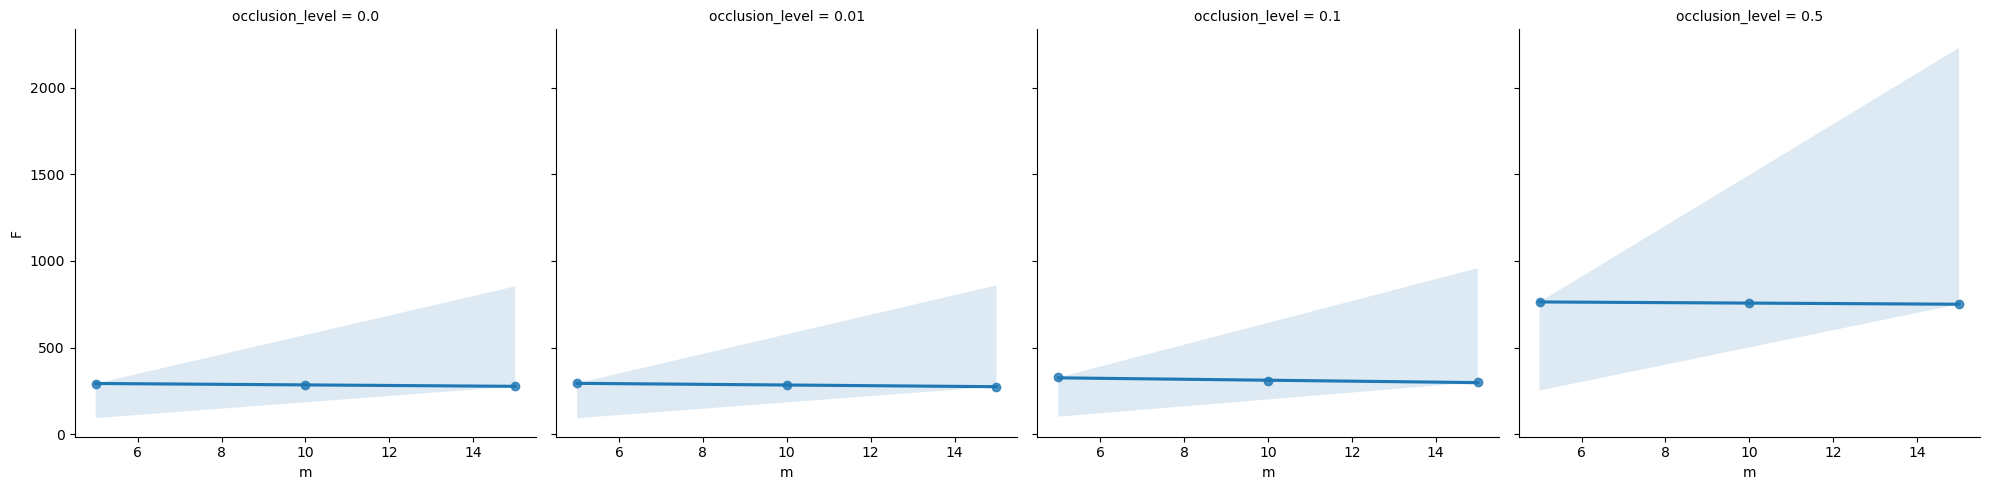

In [41]:
sns.lmplot(x = 'm', y ='F', data=df[df['delta_scaling'] == 0.0], col='occlusion_level')

In [50]:
# sns.lineplot(x = 'm', y ='F', data=df[df['delta_scaling'] == 0.0], hue='occlusion_level', style='delta_scaling')
# plt.yscale('log')

In [53]:
import matplotlib as mpl

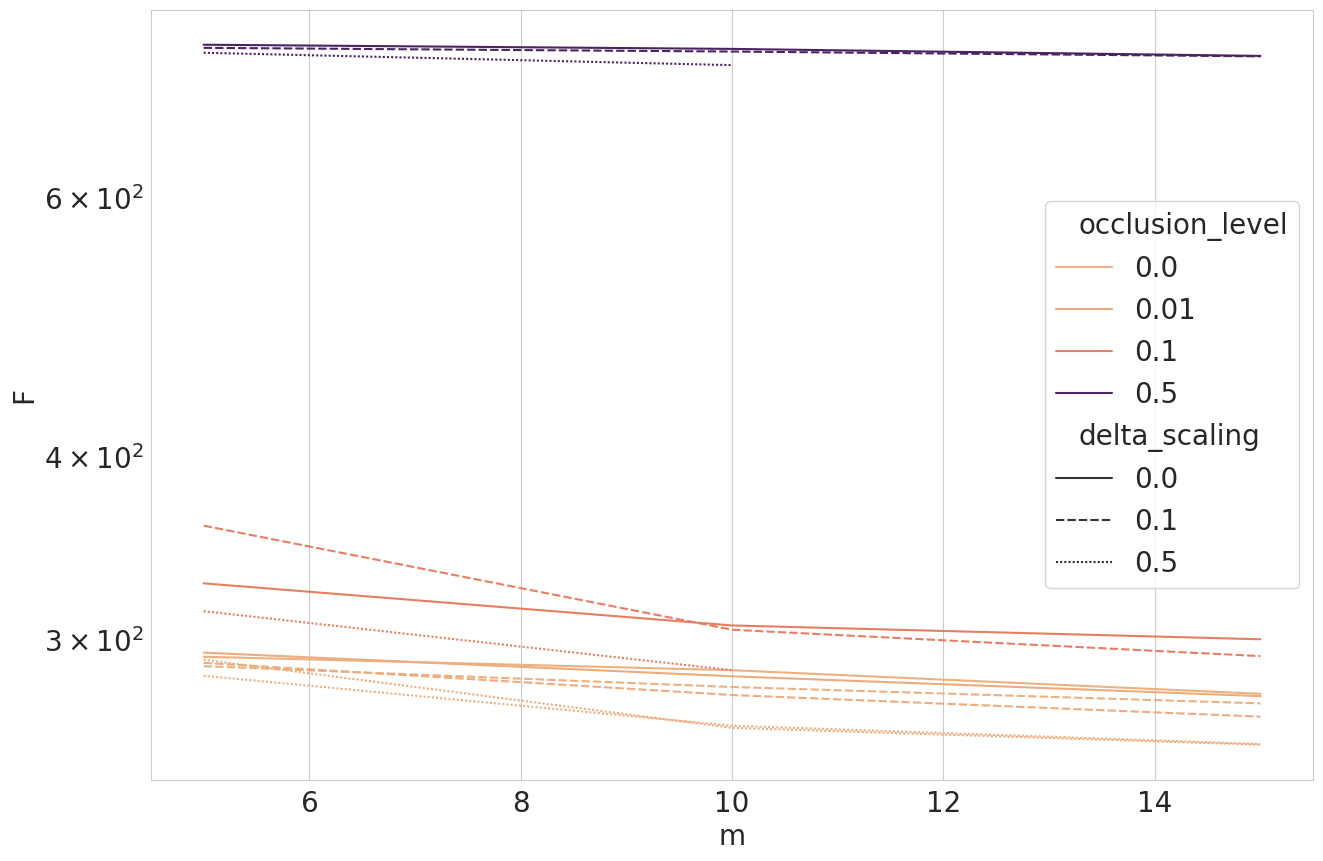

In [56]:
sns.lineplot(x = 'm', y ='F', data=df, hue='occlusion_level', style='delta_scaling', 
             palette="flare",)
plt.yscale('log')


In [100]:
df.head()

,m,delta_scaling,occlusion_level,k,L2_diff_val_gt,val_diff_singular_values,true_diff_singular_values,convergence_success,F
0,5.0,0.0,0.00,10.0,34.397977,"[31.98147861, 32.15110066, 32.45805364, 32.916...","[13.60215724, 13.67228547, 13.79958417, 13.872...",True,292.123554
1,5.0,0.0,0.01,10.0,33.820748,"[32.08071889, 32.53583891, 32.70968249, 32.884...","[14.36646201, 14.44223801, 14.62274952, 14.627...",True,294.011253
2,5.0,0.0,0.10,10.0,34.491775,"[33.40755993, 33.64541876, 34.06496926, 34.505...","[20.21584401, 20.90052743, 21.72286082, 22.383...",True,327.773955
3,5.0,0.0,0.50,10.0,34.054391,"[54.53554043, 56.32857403, 59.05478422, 61.331...","[51.28992396, 53.0190052, 55.9885169, 58.56564...",True,762.990124
4,5.0,0.1,0.00,10.0,33.542881,"[31.70553598, 32.08622028, 32.18914685, 33.200...","[13.82402424, 13.94402366, 14.09055264, 14.303...",True,287.812557


In [101]:
df['true_diff_max_sv'] = df['true_diff_singular_values'].map(lambda x: max(x))

In [102]:
df['val_diff_max_sv'] = df['val_diff_singular_values'].map(lambda x: max(x))

In [104]:
df['val_diff_max_sv_normalized'] = np.divide(df['val_diff_max_sv'], df['L2_diff_val_gt'])

In [105]:
df['true_diff_max_sv_normalized'] = np.divide(df['true_diff_max_sv'], df['L2_diff_val_gt'])

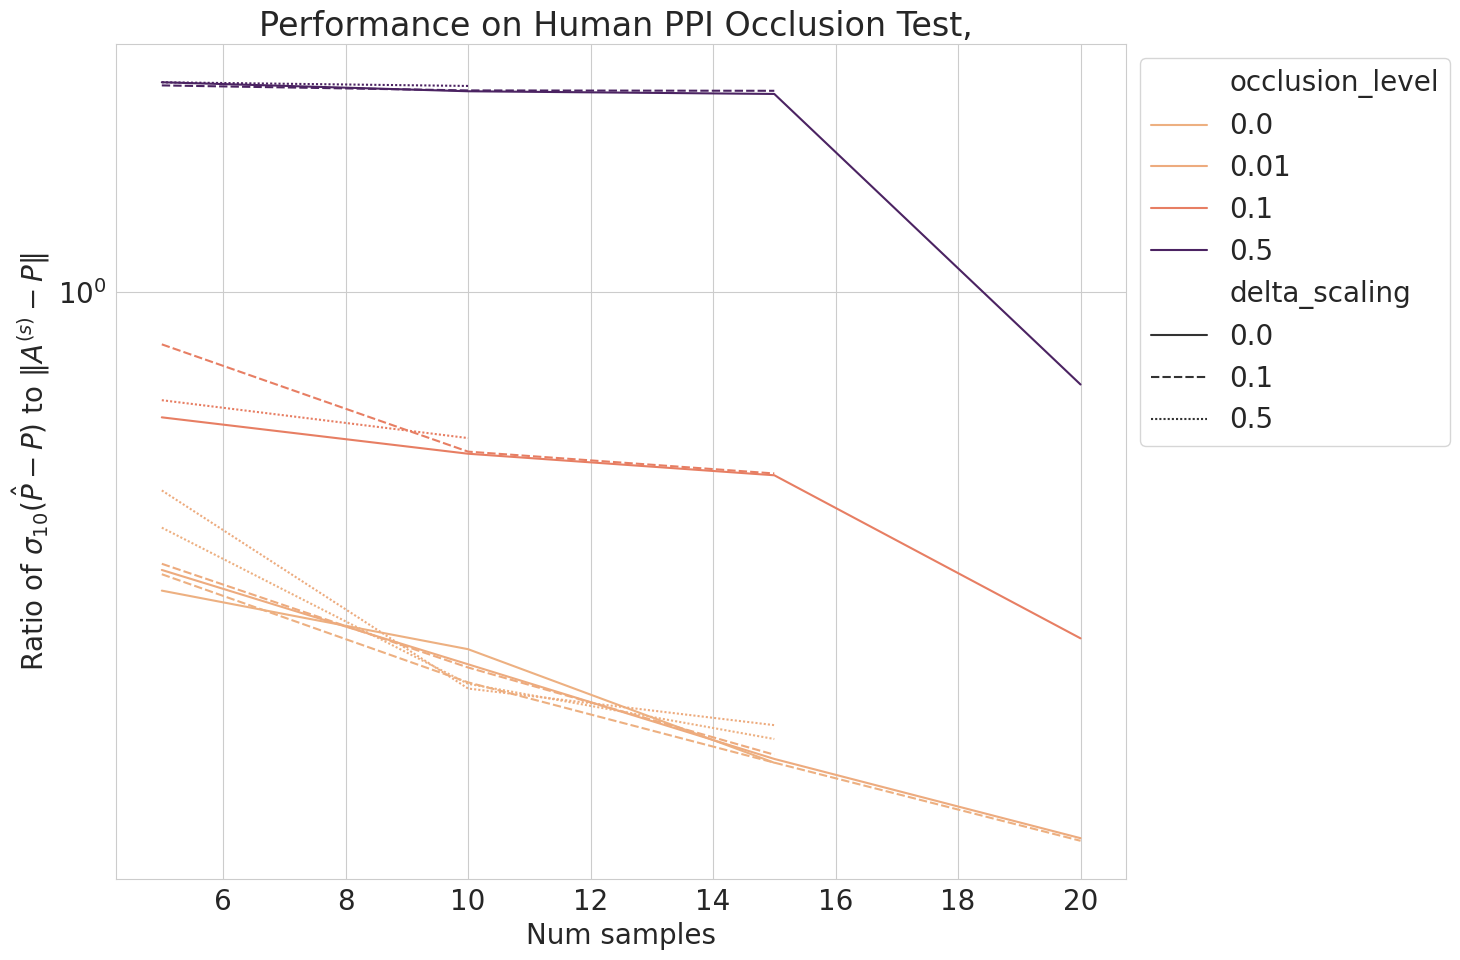

In [112]:
sns.lineplot(x = 'm', y ='true_diff_max_sv_normalized', data=df, hue='occlusion_level', style='delta_scaling', 
             palette="flare")
plt.legend(bbox_to_anchor=(1, 1))
plt.yscale('log')
plt.title('Performance on Human PPI Occlusion Test, ')
plt.xlabel('Num samples')
plt.ylabel('Ratio of $\sigma_{10}(\hat P - P )$ to $\| A^{(s)} - P \|$')
plt.tight_layout()
plt.savefig('figs/ppi-occlusion-tests/human_ppi_occlusion_many_params.png', dpi=500);

In [116]:
from datetime import datetime

In [117]:
x = datetime.now()
y = datetime.now()

In [121]:
(y - x).total_seconds()

4.2e-05

In [122]:
output = pd.DataFrame()
d = {
    'm': 5, 
    'k': 10
}

d2 = {
    'm': 6,
    'k': 1
}
output = output.append(d, ignore_index=True)

/tmp/ipykernel_768908/208024954.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(d, ignore_index=True)


In [123]:
output

,m,k
0,5,10


In [124]:
output = output.append(d2, ignore_index=True)

/tmp/ipykernel_768908/740812354.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(d2, ignore_index=True)


In [125]:
output

,m,k
0,5,10
1,6,1


In [126]:
d2.update({'z': 3})

In [128]:
d2

{'m': 6, 'k': 1, 'z': 3}

In [129]:
d2 = d2.update({'a': 5})

In [130]:
d2

In [132]:
str(datetime.now())

'2023-04-07 13:10:00.487834'

# Analyze overnight run data

In [5]:
human_ppi_df = pd.read_csv('logs/job_04_07_2023_13_30_12.csv')

In [9]:
human_ppi_df.head()

,Unnamed: 0,m,delta_scaling,occlusion_level,l2_diff_val_gt,validation_diff_svals,true_diff_svals,time_diff,fun,jac,nfev,njev,nit,status,message,x,success,hess_inv,val_diff_max_sv
0,0,5,0.0,0.0,34.171479,[30.17854509 30.37995994 30.49030285 30.558937...,[11.8266389 11.82864173 12.0347955 12.086772...,286.110266,273.307013,[-0.00069349 0.00015916 0.00040927 0.000500...,114,19,14,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,[0.19293269 0.18224663 0.18599165 0.17225983 0...,True,<5x5 LbfgsInvHessProduct with dtype=float64>,]
1,1,5,0.0,0.1,34.571593,[31.21316638 31.50025039 31.55002347 31.838565...,[15.49372233 15.50168716 15.68753878 15.748158...,256.201278,291.439089,[ 5.11590770e-05 4.54747351e-05 -3.97903932e-...,90,15,10,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,[0.20848529 0.21942588 0.23563636 0.20375158 0...,True,<5x5 LbfgsInvHessProduct with dtype=float64>,]
2,2,5,0.0,0.5,34.500781,[ 41.77815968 42.30236291 42.39024042 44.12...,[ 35.97718555 36.45061621 37.0928611 37.86...,399.885568,495.820722,[14.49627682 17.30671775 9.63465249 8.342868...,318,53,13,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,[0.56574957 0.51682056 0.54359393 0.51612749 0...,True,<5x5 LbfgsInvHessProduct with dtype=float64>,]
3,3,5,0.1,0.0,33.650228,[30.38143668 30.5276995 30.61100435 30.678103...,[11.80066498 12.00401464 12.02266726 12.153395...,319.796679,269.128419,[0.00038654 0.00023874 0.00042633 0.00056843 0...,108,18,13,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,[0.19011088 0.18427733 0.18138469 0.1846961 0...,True,<5x5 LbfgsInvHessProduct with dtype=float64>,]
4,4,5,0.1,0.1,34.312128,[31.75494975 32.39476147 32.59907953 32.772193...,[15.99121608 16.02400313 16.36166279 16.559419...,221.336446,295.009840,[ 0.00329692 0.00622435 0.01006129 -0.000613...,78,13,10,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,[0.25439023 0.22942339 0.25026652 0.23590619 0...,True,<5x5 LbfgsInvHessProduct with dtype=float64>,]


In [30]:
def parse_str_array(arr): 
    s = arr.replace('[', '')
    s = s.replace(']', '')
    s = s.replace('\n', '')

    return [np.float(x) for x in s.strip().split(' ') if len(x) > 0]

In [32]:
# human_ppi_df['validation_diff_svals'] = human_ppi_df['validation_diff_svals'].map(lambda x: parse_str_array(x))

In [33]:
human_ppi_df['true_diff_svals'] = human_ppi_df['true_diff_svals'].map(lambda x: parse_str_array(x))

In [34]:
human_ppi_df['val_diff_max_sv'] = human_ppi_df['validation_diff_svals'].map(lambda x: max(x))

In [35]:
human_ppi_df['true_diff_max_sv'] = human_ppi_df['true_diff_svals'].map(lambda x: max(x))

In [36]:
human_ppi_df['val_diff_max_sv']

0      36.955654
1      52.924671
2     119.071196
3      36.732929
4      44.757386
5     126.070812
6      35.735357
7      41.648053
8      89.436948
9      35.833080
10     42.838811
11     92.616893
12     35.407200
13     38.489793
14     82.245420
15     34.869503
16     36.845468
17     75.939991
18     34.990384
19     38.815218
20     71.227627
21     34.784559
22     35.427094
23     70.059847
24     34.827083
25     34.696190
26     61.126373
27     34.476377
28     35.128460
29     61.693767
Name: val_diff_max_sv, dtype: float64

In [37]:
human_ppi_df['val_diff_max_sv_normalized'] = np.divide(human_ppi_df['val_diff_max_sv'], human_ppi_df['l2_diff_val_gt'])

In [38]:
human_ppi_df['true_diff_max_sv_normalized'] = np.divide(human_ppi_df['true_diff_max_sv'], human_ppi_df['l2_diff_val_gt'])

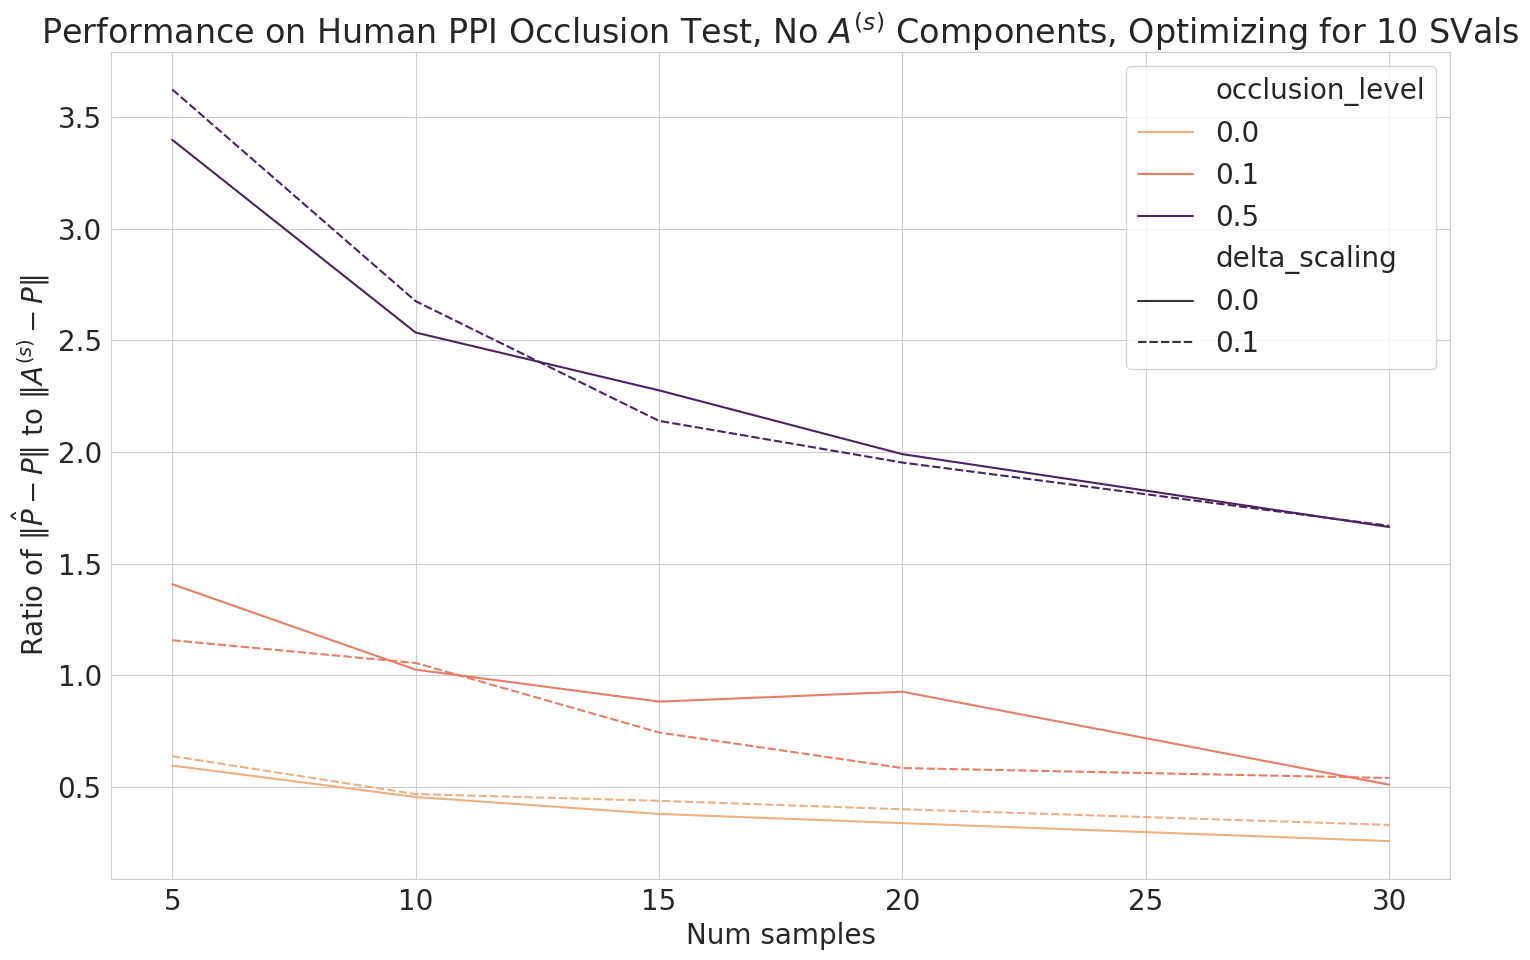

In [44]:
sns.lineplot(x = 'm', y ='true_diff_max_sv_normalized', data=human_ppi_df, hue='occlusion_level', style='delta_scaling', 
             palette="flare")
plt.legend(bbox_to_anchor=(1, 1))
# plt.yscale('log')
plt.title('Performance on Human PPI Occlusion Test, No $A^{(s)}$ Components, Optimizing for 10 SVals')
plt.xlabel('Num samples')
plt.ylabel('Ratio of $\| \hat P - P \|$ to $\| A^{(s)} - P \|$')
plt.tight_layout()
plt.savefig('figs/ppi-occlusion-tests/bfgs_results_many_runs.png', dpi=500.0)

In [45]:
human_ppi_df['total_true_loss_twenty_svals'] = human_ppi_df['true_diff_svals'].map(lambda x: sum(x))

In [47]:
human_ppi_df['total_true_loss_normalized'] = np.divide(human_ppi_df['total_true_loss_twenty_svals'], human_ppi_df['l2_diff_val_gt'])

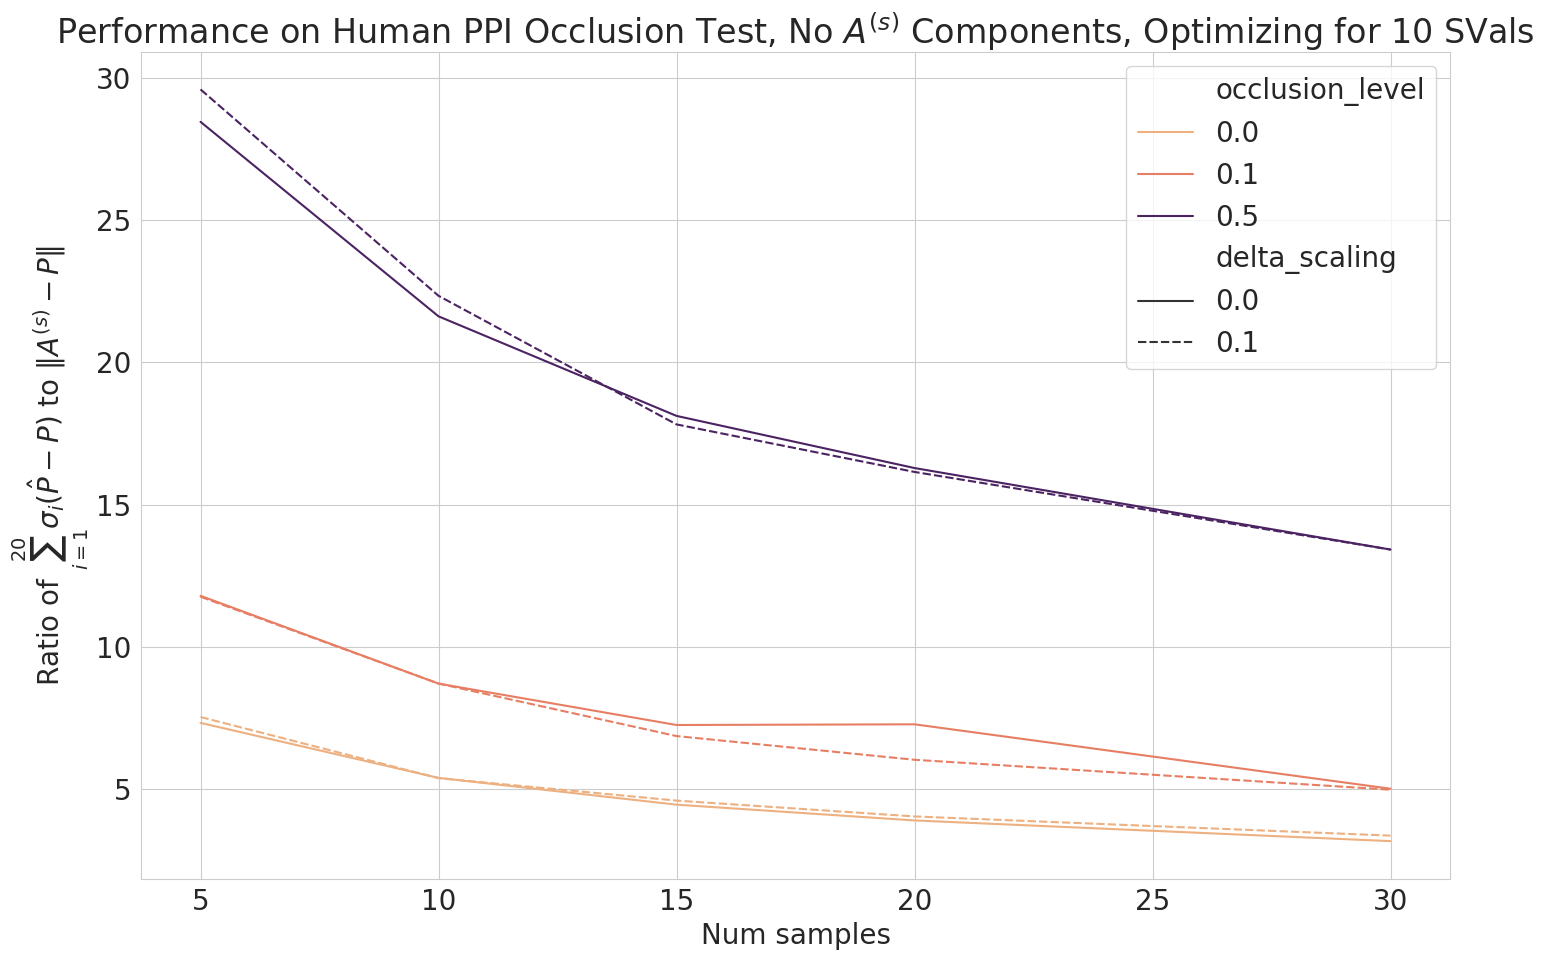

In [54]:
sns.lineplot(x = 'm', y ='total_true_loss_normalized', data=human_ppi_df, hue='occlusion_level', style='delta_scaling', 
             palette="flare")
plt.legend(bbox_to_anchor=(1, 1))
# plt.yscale('log')
plt.title('Performance on Human PPI Occlusion Test, No $A^{(s)}$ Components, Optimizing for 10 SVals')
plt.xlabel('Num samples')
plt.ylabel('Ratio of $\sum_{i=1}^{20} \sigma_i(\hat P - P )$ to $\| A^{(s)} - P \|$')
plt.tight_layout()
plt.savefig('figs/ppi-occlusion-tests/bfgs_results_top_20_svals_many_runs.png', dpi=500.0)

<BarContainer object of 19 artists>

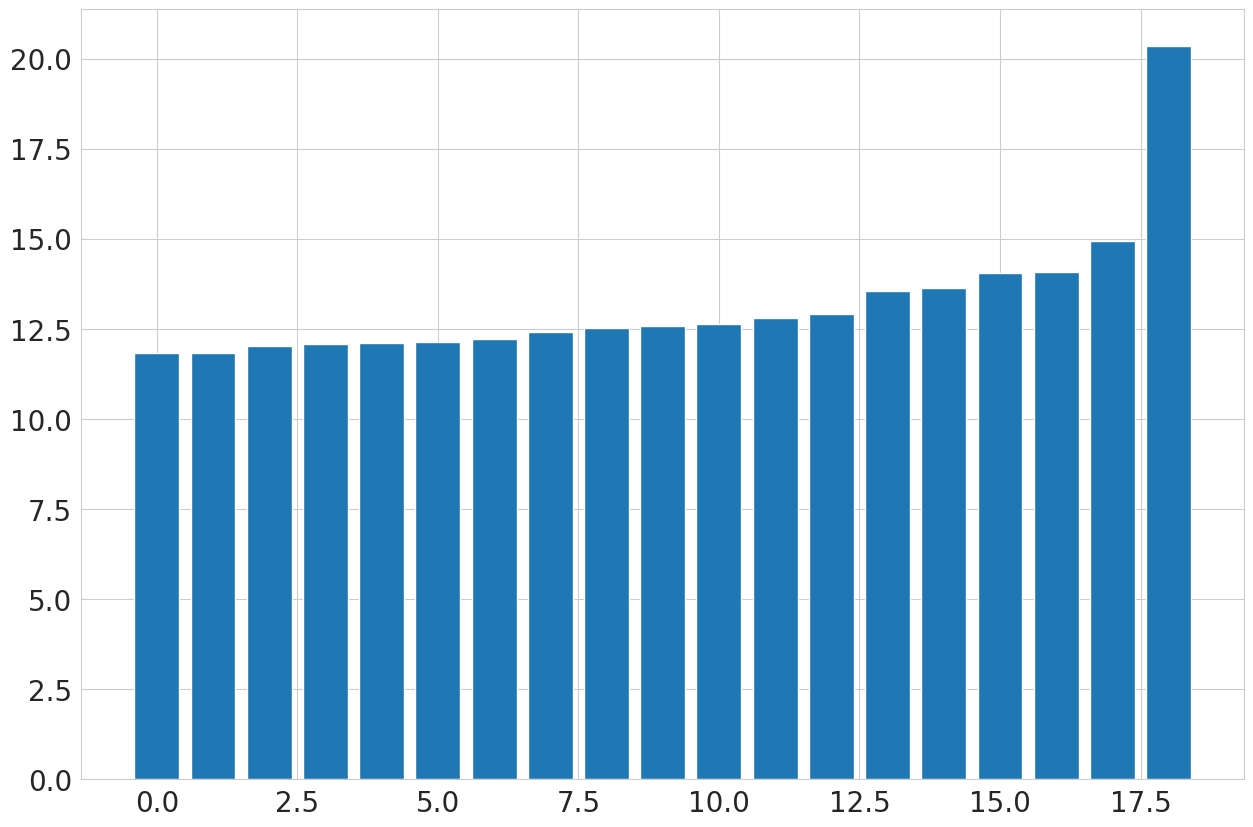

In [53]:
plt.bar(np.arange(19), human_ppi_df['true_diff_svals'].iloc[0])

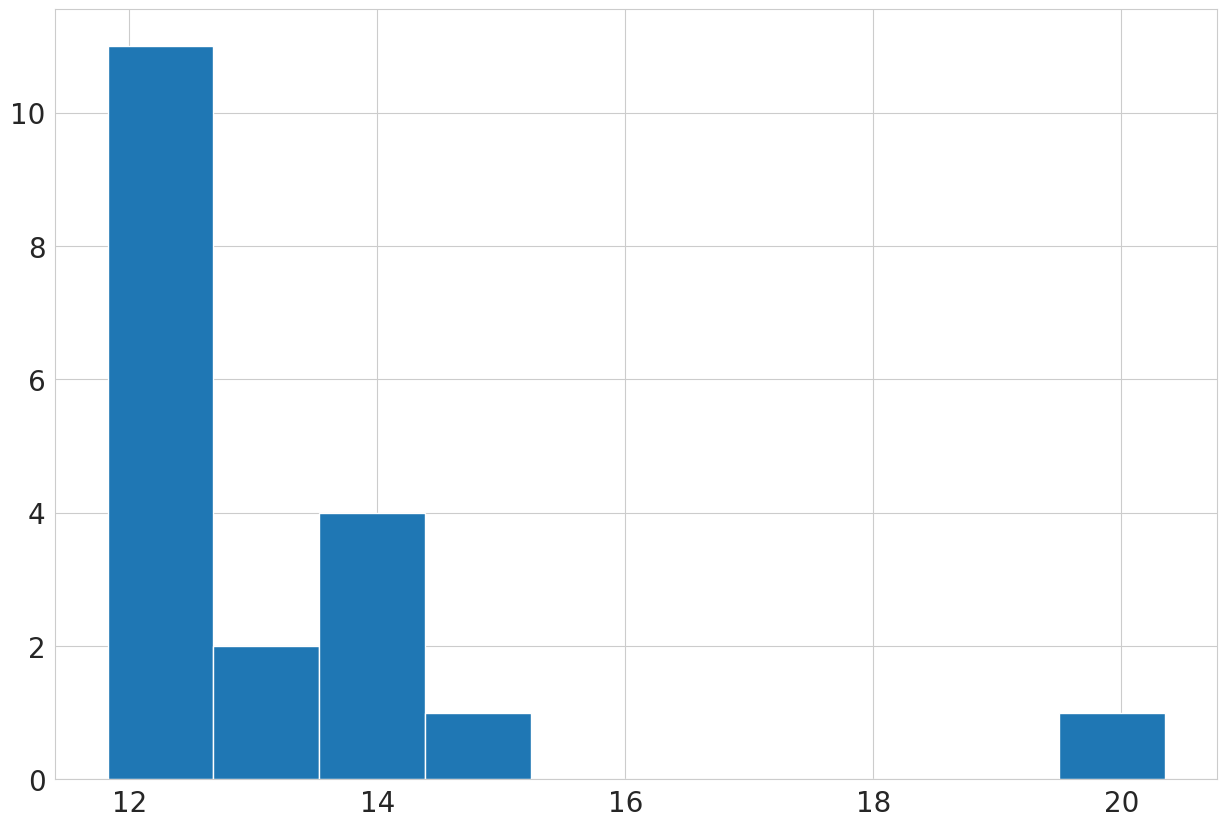

In [51]:
plt.hist(human_ppi_df['true_diff_svals'].iloc[0]);

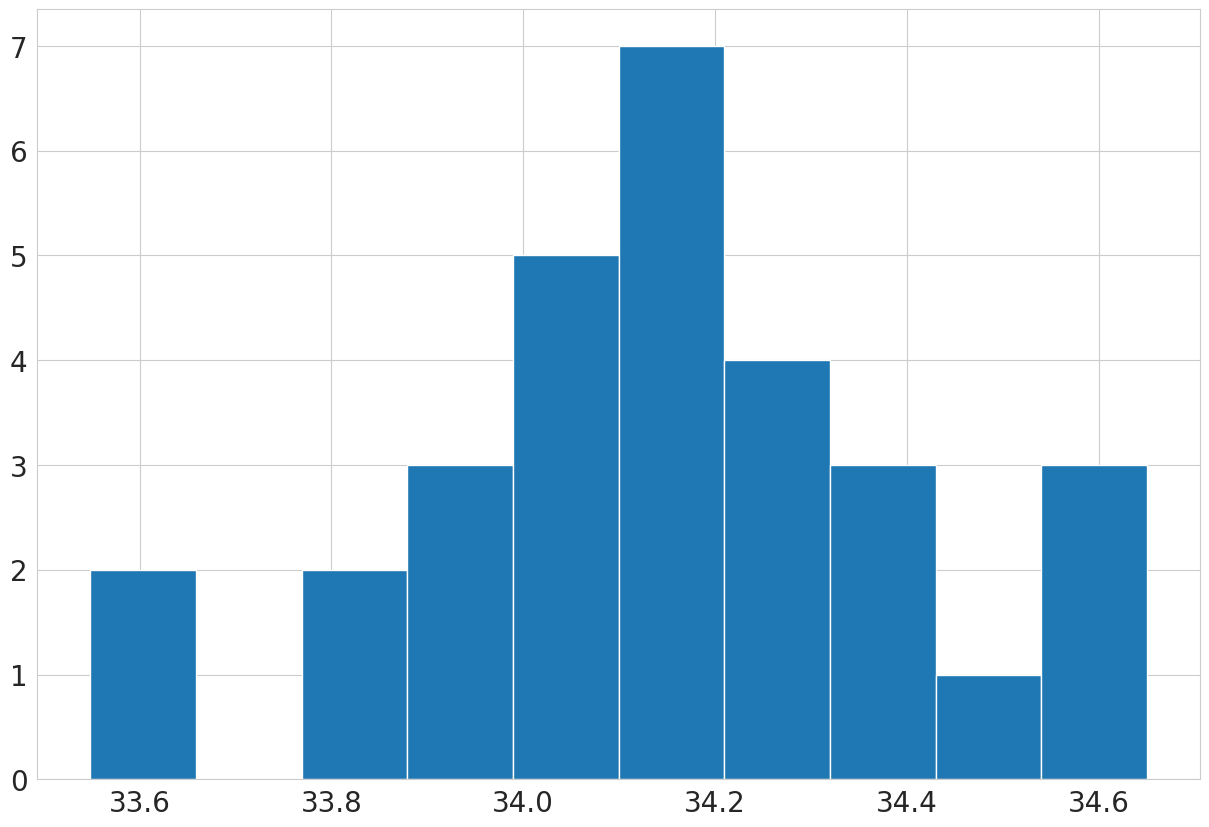

In [55]:
plt.hist(human_ppi_df['l2_diff_val_gt']);

In [57]:
human_ppi_df.to_csv('logs/human_ppi_occlusion_test_0407.csv')